# 基于综合集成学习方法对人民币美元汇率的预测

## 摘要

外汇市场的发展，加剧外汇波动对经济的影响，准确预测外汇走势成为重要研究方向。外汇表现出的复杂性非线性使得传统的线性模型难以准确预测，Bhusana Premanode 为解决此问题，提出了dEMD-SVR 模型。本文考虑到该方法在预测美元-人民币汇率中的适用性，进行改进，提出了综合集成法类EMD-PCA-K-SVR 算法。EMD 类算法具有平滑和降低噪声的能力，K-means 算法能将相似数据聚类，支持向量回归（SVR）在预测非线性和非平稳时间序列变量方面起着重要的作用。综合集成法的仿真结果表明，我们的模型在中国市场的预测中，优于原文dEMD-SVR方法、常规的机器学习方法，以及最先进的MS-GARCH 方法。

**关键词**：综合集成法；EMD；K-means；SVR；人民币美元汇率

## 总体思路方法介绍

综合集成模型能够最大限度利用各个单一模型优点，使用更多的预测信息，减少隔壁模型的偏差，提高了整体的预测度。EMD 分解常常是对数据的分量进行重构预测，这一过程中可能存在过于简化复杂关系、过拟合等问题。本文将聚类思想引入传统的EMD 分解集成学习中，能够有效避免传统模型集成学习阶段按照固定权重综合集成的缺陷，提高预测准确度。

![Image text](集成模型.png)

这一方法主要有以下三步。
- 分解：将处理后的汇率数据进行EMD 分解，得到IMFs 和残差项。
- 聚类：对分解后的IMFs 和残差项进行Kmeans 聚类，得到K 个类簇。
- 集成学习：将经过PCA 处理后的影响因子作为解释变量，聚类后的类簇作为被解释变量进行SVR回归并预测，得到最终结果。

## 数据来源与预处理

本文使用的数据集包括国际重要股指、国际重要汇率、重要商品期货、宏观经济数据。选取的时间是2013年1月1日至2022年12月31日的数据，数据来源为ifind数据终端。

在回归分析中，SVR 模型同时需要因变量和自变量。被解释变量，我们收集了美元人民币汇率。解释变量，我们从ifind上收集了日常交易数据，不包括周末和节假日，以及部分宏观月度数据，如贸易顺差等。这些数据首先有不同的时间限制基础，因为有些数据集每分钟都在变化，而另一些数据集则每小时或每天发生变化。然后，我们通过插值来调整这些偏差，并将它们转换为每日偏差。这是为了确保所有24 个数据集的时间跨度在同一天完全匹配，没有任何不规则性。下表中的数据为2013年1月1日至2022年12月31日，共计十年的自变量数据。在回归分析中，我们将美元-人民币汇率指定为被解释变量，将其他23类数据指定为解释变量。

|   | 指标名称 |   | 指标名称 |
|---|---------|---|---------|
| 1 | 上证指数 | 12 | 深证成指   |
| 2 | 道琼斯工业平均 | 13 | 恒生指数   |
| 3 | 纳斯达克 | 16 | 日经225   |
| 4 | 标普500 | 17 | 台湾加权   |
| 5 | Shibor隔夜 | 18 | 美元Libor隔夜 |
| 6 | 沪银主力连续 | 19 | 沪铝主力连续 |
| 7 | 沪金主力连续 | 20 | 沪铜主力连续 |
| 8 | 沪铅主力连续 | 21 | 沪锌主力连续 |
| 9 | 澳元兑人民币 | 22 | 加元兑人民币 |
| 10| 欧元兑人民币 | 23 | 英镑兑人民币 |
| 11| 港元兑人民币 | 24 | 日元兑人民币 |


具体预处理方法如下：
- **删除数据列**：人工删除掉缺失大量数据的重要商品期货、股指期货、汇率数据列。
- **插值处理**：去除掉空值数据，并对空缺值以及周末数据进行插值处理。将月度数据按照统计日往前插值成日度数据。
- **标准化数据**：使用Z-score 标准化原数据。该方法将数据按其特征的均值为中心，然后通过除以标准差来缩放，使得数据的均值为0，标准差为1。

In [1]:
# 数据处理部分
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')


def data_preprocess(data_file_name):
    data = pd.read_excel(data_file_name + '.xlsx')
    # 插值处理，去除空值
    data.iloc[:, 1:] = data.iloc[:, 1:].interpolate(method='linear', limit_direction='both')
    # 标准化数据
    scaler = StandardScaler()
    data.iloc[:, 1:] = scaler.fit_transform(data.iloc[:, 1:])
    data_pre = pd.DataFrame(data, columns=data.columns)

    data_pre.to_csv(data_file_name + '_pre.csv', index=False, encoding ='utf-8-sig')
    return data_pre

data_preprocess('data')

指标名称  中间价:美元兑人民币    上证综合指数    深证成份指数  道琼斯工业平均指数  纳斯达克综合指数   
0    2024-11-05    1.203278  1.007890  0.021223   2.001714  2.064251  \
1    2024-11-04    1.274589  0.704640 -0.160072   2.001714  2.064251   
2    2024-11-01    1.248658  0.553766 -0.269532   2.040713  2.079861   
3    2024-10-31    1.292513  0.584612 -0.197972   1.997000  2.042159   
4    2024-10-30    1.345901  0.530977 -0.229803   2.054241  2.175699   
...         ...         ...       ...       ...        ...       ...   
2356 2016-01-08   -0.848364  0.215681 -0.041010  -1.851116 -1.460926   
2357 2016-01-07   -0.844551 -0.026864 -0.108838  -1.825733 -1.448998   
2358 2016-01-06   -0.971158  0.908558  0.399768  -1.766323 -1.410888   
2359 2016-01-05   -1.026453  0.615775  0.264356  -1.728148 -1.396393   
2360 2016-01-04   -1.078697  0.649544  0.347653  -1.729619 -1.393356   

      标准普尔500指数      恒生指数  东京日经225指数    台湾加权指数  ...  中间价:港元兑人民币  中间价:加元兑人民币   
0      2.239722 -0.665786   2.161958  2.480082  ...    1.319430   -0.368623  \
1      2.239722 -0.769268   2.127616  2.443682  ...    1.385604   -0.326578   
2      2.255737 -0.783654   2.093273  2.395978  ...    1.361540   -0.381671   
3      2.232525 -0.828183   2.260829  2.401171  ...    1.412675   -0.265686   
4      2.340103 -0.813275   2.292811  2.406365  ...    1.475841   -0.204794   
...         ...       ...        ...       ...  ...         ...         ...   
2356  -1.528461 -0.796068  -1.225887 -1.436114  ...   -0.701884   -3.672741   
2357  -1.507526 -0.824413  -1.214574 -1.446903  ...   -0.689852   -3.586477   
2358  -1.460636 -0.671947  -1.145441 -1.411293  ...   -0.816184   -3.539358   
2359  -1.434343 -0.622988  -1.115654 -1.389483  ...   -0.870327   -3.479916   
2360  -1.438369 -0.590397  -1.103101 -1.379405  ...   -0.921461   -3.407425   

      中间价:英镑兑人民币  Shibor:隔夜  收盘价:沪锌指数  收盘价:沪铝指数  收盘价:黄金指数  收盘价:沪锡指数  收盘价:沪银指数   
0       1.255759  -1.261328  1.131854  1.548203  2.989791  1.486188  2.968383  \
1       1.335892  -1.241549  1.158629  1.503825  2.992506  1.500461  2.981033   
2       1.177512  -1.221771  1.074756  1.486009  3.040688  1.375689  2.943084   
3       1.355061  -1.221771  1.209599  1.463333  3.107305  1.368268  3.109337   
4       1.537954  -1.162435  1.142500  1.509332  3.139087  1.364086  3.261133   
...          ...        ...       ...       ...       ...       ...       ...   
2356    2.550773  -0.035054 -2.751820 -1.769169 -1.428450 -1.533595 -1.245769   
2357    2.483524  -0.015276 -2.752465 -1.792815 -1.430825 -1.539966 -1.244865   
2358    2.439215   0.004503 -2.693108 -1.788928 -1.489638 -1.529341 -1.283718   
2359    2.500494   0.044060 -2.609880 -1.762366 -1.502080 -1.523273 -1.284621   
2360    2.425703   0.044060 -2.663430 -1.800266 -1.525831 -1.546106 -1.291850   

      收盘价:沪铅指数  
0     0.289944  
1     0.340596  
2     0.331133  
3     0.191980  
4     0.268236  
...        ...  
2356 -1.846893  
2357 -1.890309  
2358 -1.712750  
2359 -1.671004  
2360 -1.760062  

[2361 rows x 22 columns]

## 汇率数据处理：类EMD分解+Kmeans聚类

### 经验模态分解（Empirical Mode Decomposition, EMD）

经验模态分解（Empirical Mode Decomposition, EMD）是指经验模态分解模型，是一种用于信号处理的非线性时频分析方法，主要用途是对非平稳和非线性信号进行分析和处理。

EMD的主要思想是将信号分解成若干个本征模态函数IMF的叠加，其中每个本征模态函数具有单调的频率和振幅，并且它们之间的任何线性组合仍然是本征模态函数。

#### 本征模态分量（Intrinsic Mode Functions, IMF）

本征模态分量（Intrinsic Mode Functions, IMF）就是原始信号被EMD分解之后得到的各层信号分量。根据定义，IMF应满足以下两个条件：

- 在整个数据集中，极值的数量和零点的数量必须相等或最多相差一个
- 在任何一点，由局部最大值定义的包络和由局部最小值定义的包络的平均值为零

在实践中，定义了限制的标准差$S_D$并借此判断分解的信号是否满足IMF。其中$\epsilon$取值在0.2-0.3之间。

$$ S_D = \sum_{k=1}^{T} \frac{{\left | h_{1{k−1}} (t) − h_{1k} \right |}^2}{{\left [ h_{1{k−1} } (t)\right ]}^2} < \epsilon$$

#### EMD分解的具体步骤

1. 采用插值法进行计算信号的极大值$e_{max} (t)$和极小值$e_{min} (t)$包络。
2. 通过计算极大值包络和极小值包络的平均值$m_{1} (t)$，得到信号的平均值，并将其与信号的差异定义为$x_1 (t)−m_1 (t)=h_1 (t)$。 其中，$h_1 (t)$是中间信号。
3. 通过限制的标准差$SD$值来评判是否是IMF。如果$h_1 (t)$不满足IMF的条件，就以该中间信号作为基础返回第一步重新处理，同时将此IMF的差异定义为
   $$ h_1 (t)− m_1 (t)=h_1 (t) $$
4. 重复步骤1到3，直到第k次得到第一个局部平均值为零的IMF $h_{1k} (t)$，将$h_{1k} (t)$定义为$c_1 (t)$
   $$ h_{1{k−1}} (t)− m_{1k} (t)= h_1k (t) $$
5. 最后，计算第一个残差$res_1 (t)=x_1 (t)−c_1 (t)$。这个残差$res_1 (𝑡)$将被作为下一个IMF的新原始数据来计算。

经过EMD分解以后，最后将原信号分为了N个本征模态分量$c_{.} (t)$和非震荡趋势项$res (t)$。

$$ x(t) = \sum_{n=1} ^N c_{n} (t) + res (t) $$


### EEMD分解


EMD分解过程中可能出现模式混乱，同一个IMF中含有多个不同频率的序列，或多个相似频率的信号在不同IMF中出现，使IMF失去其原有的物理含义。因此，在原有的EMD模型上改进，提出了全局经验集合模态分解EEMD。

EEMD中假设原始数据中包含了噪声。为避免模态混叠现象，在原始数据中加入相关的白噪声序列，多次分解后，其平均值会更加逼近实际值，加入的白噪声认为是分解时收到的随机干扰。

#### EEMD分解的具体步骤

1. 向原始数据加入白噪声序列。一般来说，加入标准差设定为0.1或0.2的噪声，集成次数$ m $设定为100次或200次得到的结果是最优的。得到新的数据$ x_{noise} (t) $。
   $$ x_{noise} (t) = x(t) + \omega_{noise} (t) $$
2. 对$ x_{noise} (t)$进行EMD分解，得到相应的IMF分量和趋势项。
3. 加入不同的白噪声序列重复$M$次并求均值，得到最终的IMF分量和最终的趋势项。


EEMD模型认为，在均值以后可以抵消加入的噪声，而多次重复分解的方式可以让结果更加稳定。EEMD相对于EMD在抑制伪模态和伪振荡、提高分解结果的稳定性、噪声适应性和参数选择的简化等方面具有优势。这使得EEMD在处理实际信号分析中更具可靠性和实用性。

### CEEMDAN分解


CEEMDAN（Complete Ensemble Empirical Mode Decomposition with Adaptive Noise）是一种改进的经验模态分解方法，结合了EEMD和自适应噪声的思想。CEEMADAN从EMD的基础上加以改进，同时借用了EEMD方法中加入高斯噪声和通过多次叠加并平均以抵消噪声的思想。

#### CEEMDAN分解的具体步骤

1. 确定白噪声的幅值$\epsilon$和迭代次数$K$。
2. 在原数据上加入白噪声。
3. 对数据进行EMD分解，得到$l$个$IMF1_i$和剩余分量，并对这一组IMF求平均得到$IMF1 = \frac{\sum IMF1_i}{l}$。
4. 更新残差值$res_1 (t) = x(t) - IMF1$作为新的输入原始变量。
5. 重复步骤2-4，得到最终分解结果。


CEEMDAN通过引入随机扰动、多次重复分解和自适应噪声的方式，增强了分解的稳定性和鲁棒性，并减少了伪模态和伪振荡的问题，处理非线性和非平稳信号时更具优势。


In [2]:
def read_predata(file_name):
    data = pd.read_csv(file_name, index_col=0,).sort_index(ascending=True)
    return data

read_predata('data_pre.csv')

中间价:美元兑人民币    上证综合指数    深证成份指数  道琼斯工业平均指数  纳斯达克综合指数  标准普尔500指数   
指标名称                                                                         
2016-01-04   -1.078697  0.649544  0.347653  -1.729619 -1.393356  -1.438369  \
2016-01-05   -1.026453  0.615775  0.264356  -1.728148 -1.396393  -1.434343   
2016-01-06   -0.971158  0.908558  0.399768  -1.766323 -1.410888  -1.460636   
2016-01-07   -0.844551 -0.026864 -0.108838  -1.825733 -1.448998  -1.507526   
2016-01-08   -0.848364  0.215681 -0.041010  -1.851116 -1.460926  -1.528461   
...                ...       ...       ...        ...       ...        ...   
2024-10-30    1.345901  0.530977 -0.229803   2.054241  2.175699   2.340103   
2024-10-31    1.292513  0.584612 -0.197972   1.997000  2.042159   2.232525   
2024-11-01    1.248658  0.553766 -0.269532   2.040713  2.079861   2.255737   
2024-11-04    1.274589  0.704640 -0.160072   2.001714  2.064251   2.239722   
2024-11-05    1.203278  1.007890  0.021223   2.001714  2.064251   2.239722   

                恒生指数  东京日经225指数    台湾加权指数  中间价:澳元兑人民币  ...  中间价:港元兑人民币   
指标名称                                                   ...               
2016-01-04 -0.590397  -1.103101 -1.379405   -0.554973  ...   -0.921461  \
2016-01-05 -0.622988  -1.115654 -1.389483   -0.757777  ...   -0.870327   
2016-01-06 -0.671947  -1.145441 -1.411293   -0.808479  ...   -0.816184   
2016-01-07 -0.824413  -1.214574 -1.446903   -1.011283  ...   -0.689852   
2016-01-08 -0.796068  -1.225887 -1.436114   -1.112685  ...   -0.701884   
...              ...        ...       ...         ...  ...         ...   
2024-10-30 -0.813275   2.292811  2.406365   -0.808479  ...    1.475841   
2024-10-31 -0.828183   2.260829  2.401171   -0.808479  ...    1.412675   
2024-11-01 -0.783654   2.093273  2.395978   -0.808479  ...    1.361540   
2024-11-04 -0.769268   2.127616  2.443682   -0.757777  ...    1.385604   
2024-11-05 -0.665786   2.161958  2.480082   -0.808479  ...    1.319430   

            中间价:加元兑人民币  中间价:英镑兑人民币  Shibor:隔夜  收盘价:沪锌指数  收盘价:沪铝指数  收盘价:黄金指数   
指标名称                                                                          
2016-01-04   -3.407425    2.425703   0.044060 -2.663430 -1.800266 -1.525831  \
2016-01-05   -3.479916    2.500494   0.044060 -2.609880 -1.762366 -1.502080   
2016-01-06   -3.539358    2.439215   0.004503 -2.693108 -1.788928 -1.489638   
2016-01-07   -3.586477    2.483524  -0.015276 -2.752465 -1.792815 -1.430825   
2016-01-08   -3.672741    2.550773  -0.035054 -2.751820 -1.769169 -1.428450   
...                ...         ...        ...       ...       ...       ...   
2024-10-30   -0.204794    1.537954  -1.162435  1.142500  1.509332  3.139087   
2024-10-31   -0.265686    1.355061  -1.221771  1.209599  1.463333  3.107305   
2024-11-01   -0.381671    1.177512  -1.221771  1.074756  1.486009  3.040688   
2024-11-04   -0.326578    1.335892  -1.241549  1.158629  1.503825  2.992506   
2024-11-05   -0.368623    1.255759  -1.261328  1.131854  1.548203  2.989791   

            收盘价:沪锡指数  收盘价:沪银指数  收盘价:沪铅指数  
指标名称                                      
2016-01-04 -1.546106 -1.291850 -1.760062  
2016-01-05 -1.523273 -1.284621 -1.671004  
2016-01-06 -1.529341 -1.283718 -1.712750  
2016-01-07 -1.539966 -1.244865 -1.890309  
2016-01-08 -1.533595 -1.245769 -1.846893  
...              ...       ...       ...  
2024-10-30  1.364086  3.261133  0.268236  
2024-10-31  1.368268  3.109337  0.191980  
2024-11-01  1.375689  2.943084  0.331133  
2024-11-04  1.500461  2.981033  0.340596  
2024-11-05  1.486188  2.968383  0.289944  

[2361 rows x 21 columns]

In [ ]:
# -*- coding: utf-8 -*-
# 分解结果不满足正态性，代码分解

import math
import numpy as np 
import pylab as pl
import matplotlib.pyplot as plt
import scipy.signal as signal
from scipy import fftpack  
import scipy.signal as signal
from scipy import interpolate
from scipy.stats import t, uniform, norm
import pandas as pd
from PyEMD import EMD,EEMD,CEEMDAN
import ewtpy
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats

def visualize_emd(d, emd_imf, emd_res, method):
    '''
    Parameters
    ----------
    emd_res : list of numpy arrays
        分解结果

    '''
    N = emd_imf.shape[0] + 1
    t = list(range(len(d)))
    print(t)
    plt.figure(figsize = (35,20), dpi = 108)
    plt.subplot(N+1,1,1)
    plt.plot(t, d, 'r')
    plt.title(method + " Input signal")


    for n, imf in enumerate(emd_imf):
        plt.subplot(N+1,1,n+2)
        plt.plot(t, imf, 'g')
        plt.title("IMF "+str(n+1))


    plt.subplot(N+1, 1, N+1)
    plt.plot(t, emd_res, 'orange')
    plt.title("res")


### 数据检验结果

正态性检验和单位根检验以验证数据的线性和稳定性。
正态性检验使用了Anderson-Darling 检验、Kolmogorov-Smirnov 检验和Shapiro-Wilks 检验，单位根检验使用了Augmented Dickey-Fuller 检验和Kwiatkowskiphillips-schmidt-Shin 检验。根据结果分析发现，在正态性检验中，均拒绝了原假设，即拒绝了数据符合正态分布；在单位根检验中在5% 的条件下均无法拒绝原假设。因此本文认为数据是非平稳和非线性的。

In [4]:
d = read_predata('data_pre.csv').iloc[:, 0]

adf = adfuller(d) 
k = kpss(d)
stat = stats.chisquare(d)
ad = stats.anderson(d, dist="norm")
ks, ks_p = stats.kstest(d,"norm")
shapiro_test = stats.shapiro(d)
s_p = shapiro_test.pvalue



dic_p = {"ks_test": ks_p, "shapiro_test":shapiro_test[1],\
       "adf_test": adf[1], "kpss": k[1]}

dic_stat = {"ks_test": ks, "shapiro_test":shapiro_test[0],\
       "adf_test": adf[0], "kpss": k[0]}

C:\Users\HP\AppData\Local\Temp\ipykernel_14484\2414982652.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  k = kpss(d)


In [5]:
dic_p, dic_stat

({'ks_test': 2.8775818065947806e-14,
  'shapiro_test': 2.481095139778898e-28,
  'adf_test': 0.2825225201978604,
  'kpss': 0.01},
 {'ks_test': 0.08202863814188777,
  'shapiro_test': 0.9471267461776733,
  'adf_test': -2.009271969213827,
  'kpss': 1.5740923946354266})

### 类EMD方法分解结果

分别对数据进行EMD 分解、EEMD 分解和CEEMDAN 分解，其分解结果如图所示。

其中，eemd.trials = 1000设置了EEMD算法的试验次数为1000次。这意味着算法会在原始信号上添加1000次不同量的高斯白噪声，并分别进行HHT分解，最后取所有试验结果的平均值作为最终的分解结果。
ceemd.trials = 1000设置了CEEMDAN算法的试验次数为1000。在CEEMDAN算法中，每次试验都会生成不同的IMFs，通过多次试验取平均值来减少随机性。

In [6]:
emd = EMD()

emd_IMF = emd.emd(np.array(d))
emd_res = emd_IMF[-1,:]
emd_imf = emd_IMF[:-1,:]


ewt,  mfb ,boundaries = ewtpy.EWT1D(np.array(d), N = 10)
eemd = EEMD()
eemd.trials = 1000
eemd.noise_seed(12345)
eemd_imf = eemd.eemd(np.array(d))
eemd_res = eemd.get_imfs_and_residue()[1]



ceemd = CEEMDAN()
ceemd.trials = 1000
ceemd_IMF = ceemd(np.array(d))
ceemd_res = ceemd_IMF[-1,:]
ceemd_imf = ceemd_IMF[:-1,:]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

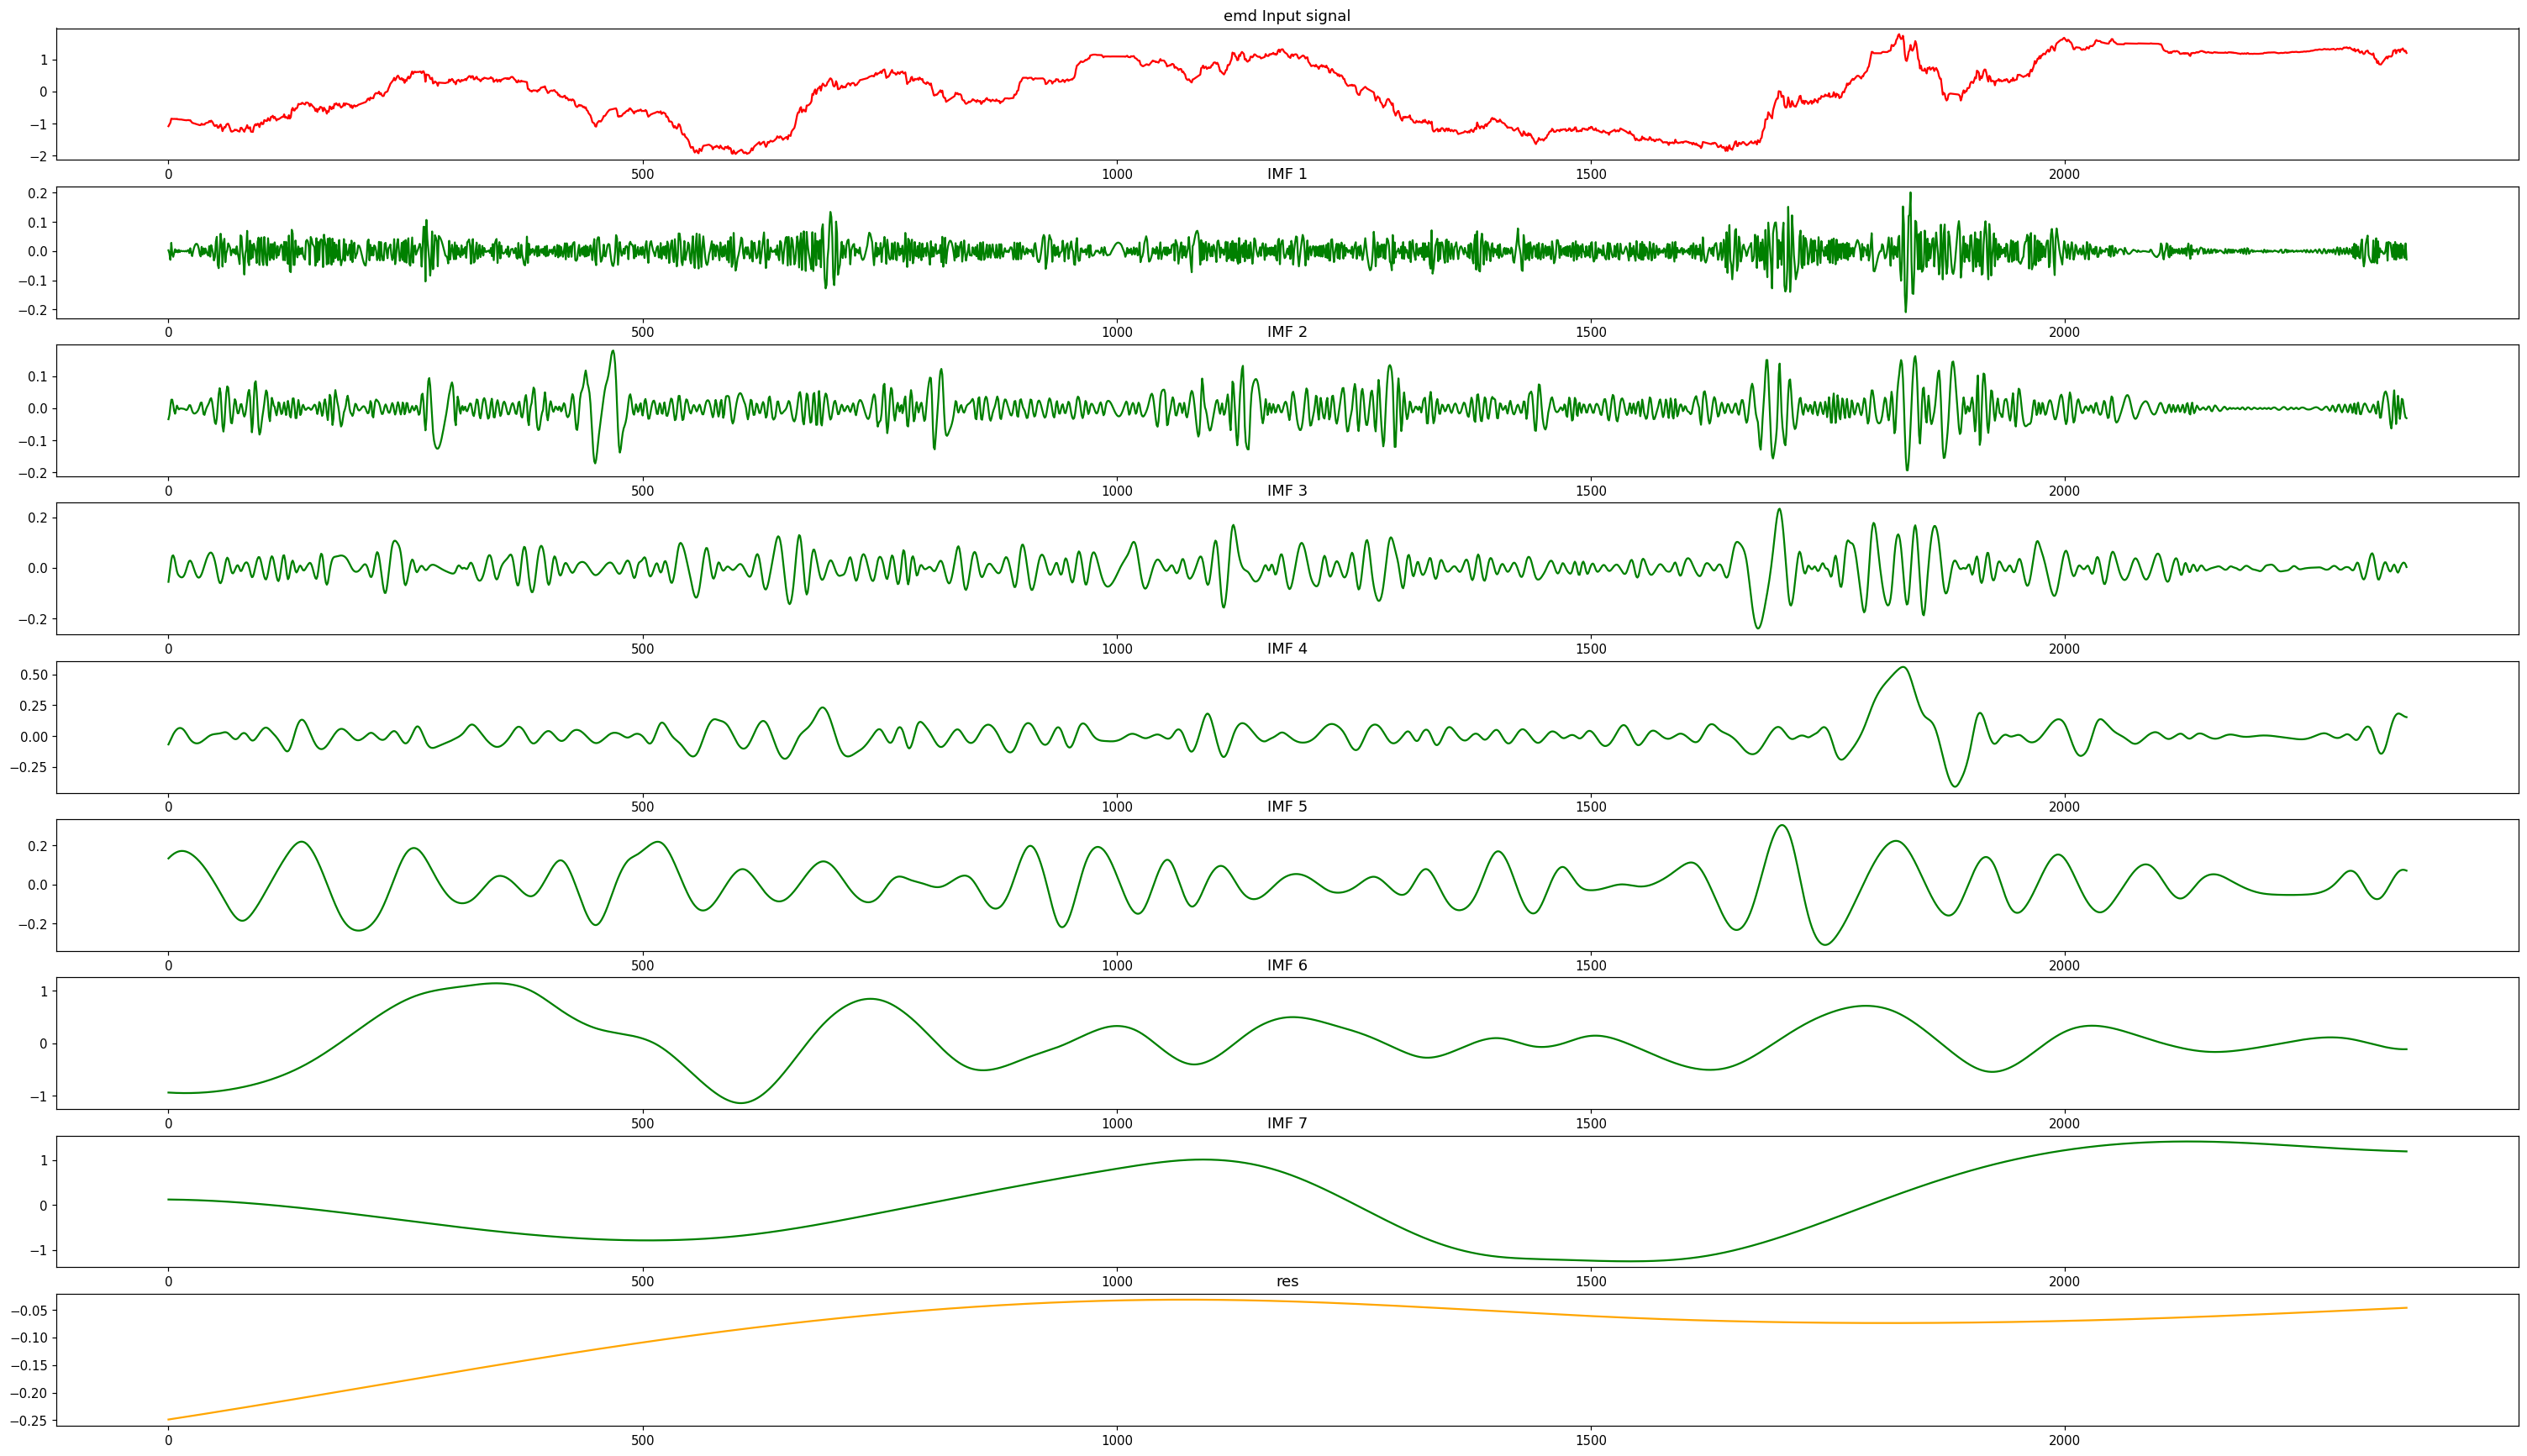

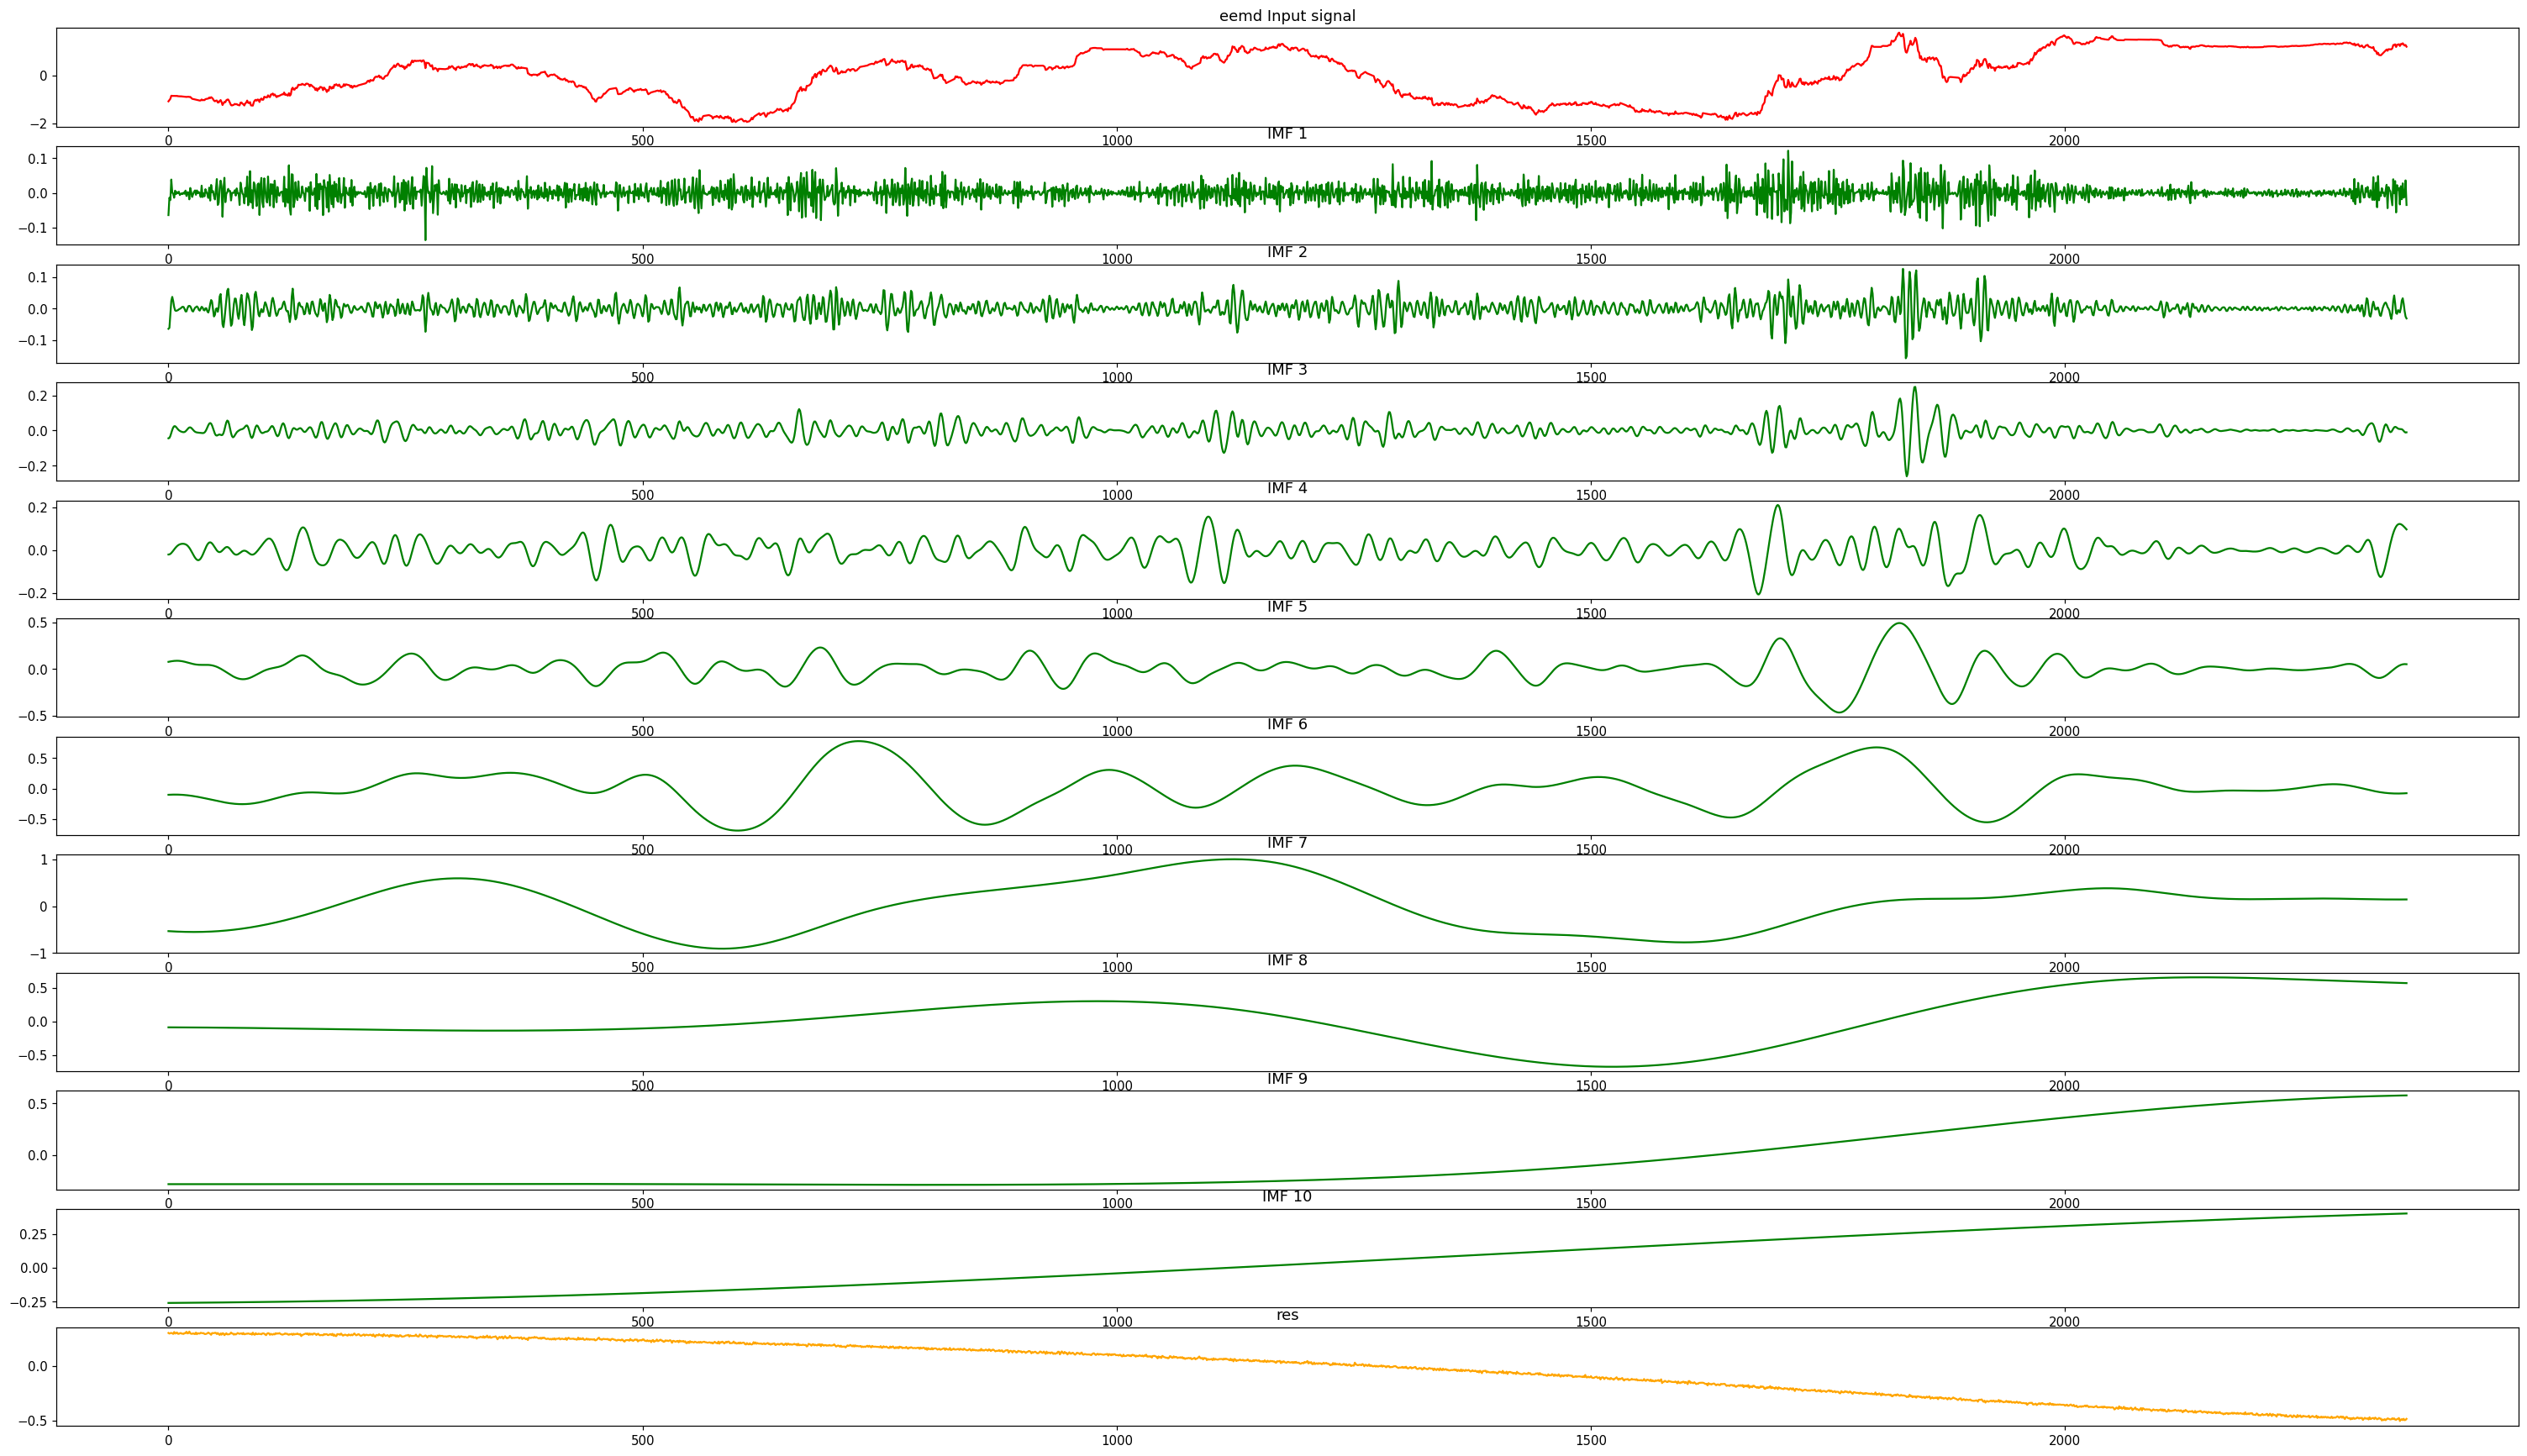

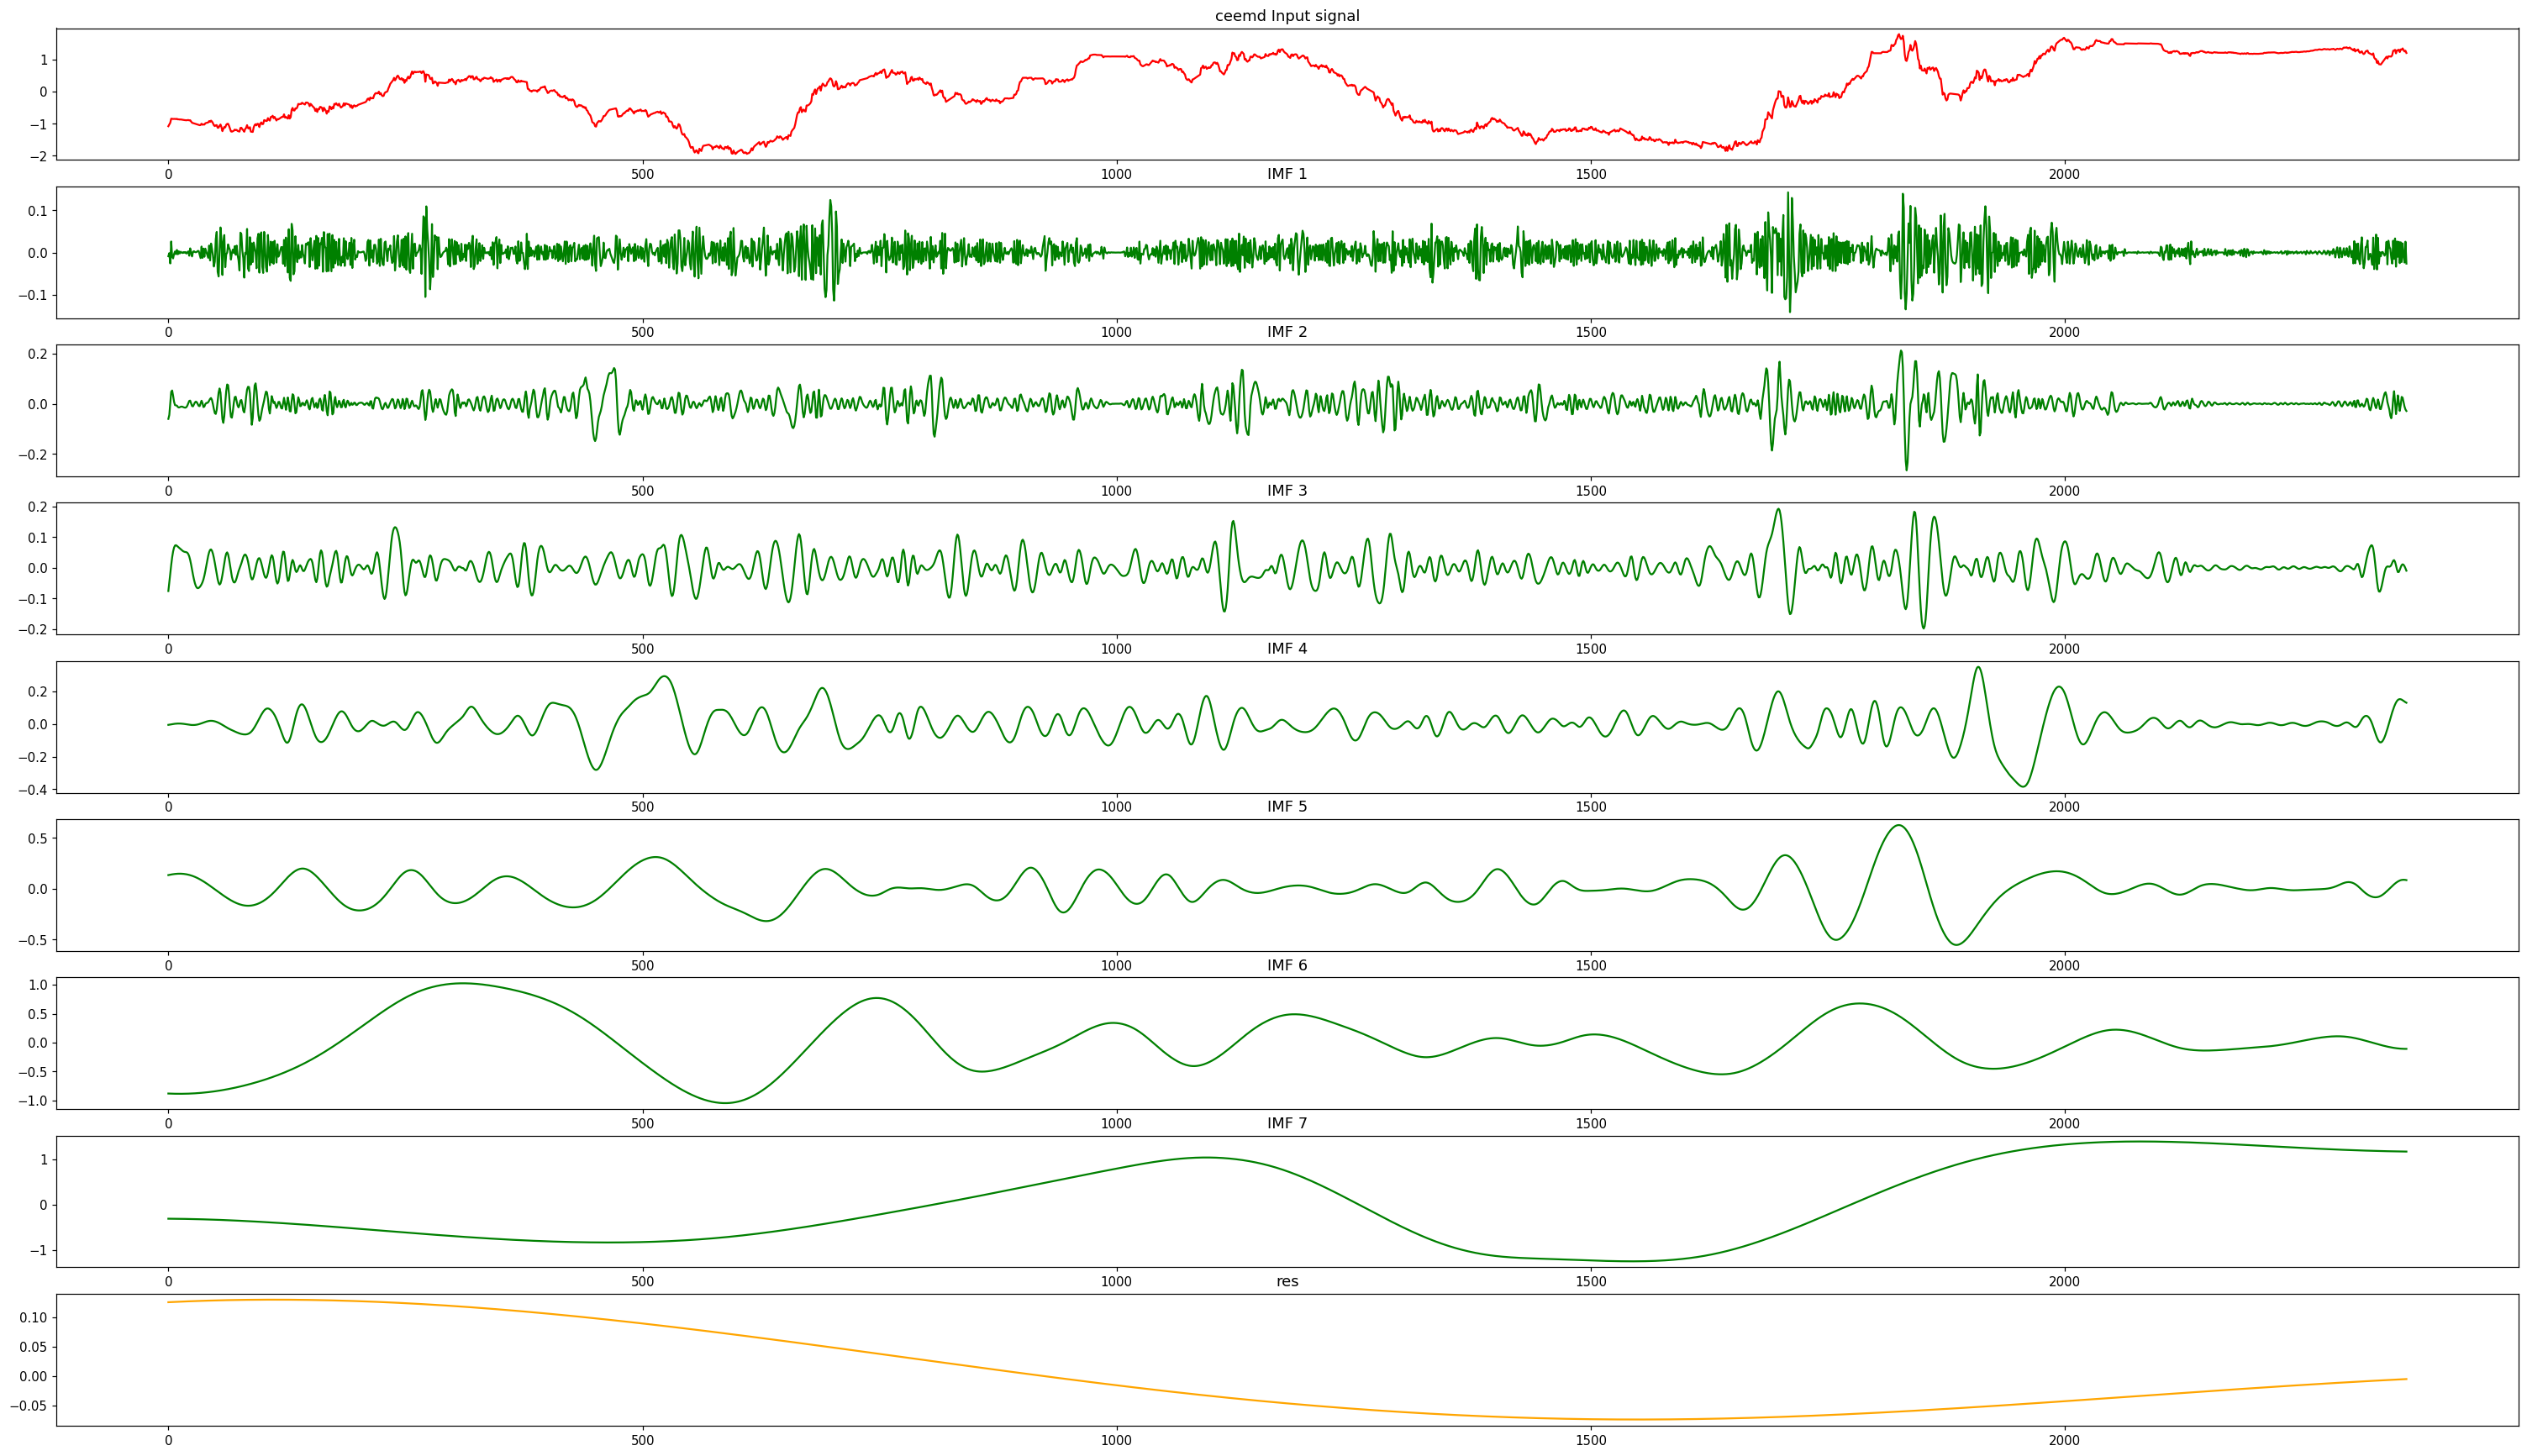

In [7]:
visualize_emd(d, emd_imf, emd_res, "emd")
visualize_emd(d, eemd_imf, eemd_res, "eemd")
visualize_emd(d, ceemd_imf, ceemd_res, "ceemd")

In [8]:
emd_data = [emd_imf, eemd_imf, ceemd_imf]
imf_names = ["emd", "eemd", "ceemd"]
d = read_predata('data_pre.csv').iloc[:, 0]
for data, n in zip(emd_data, imf_names):
    temp = pd.DataFrame(data).T
    temp.index = d.index
    temp.columns = [f"imf_{i+1}" for i in range(temp.shape[1])]
    temp.to_csv(f"{n}_imf.csv")
    

### Kmeans聚类

K-means聚类是一种常用的无监督学习方法，用于将数据点分成具有相似特征的若干个簇(cluster)。它的目标是通过最小化数据点到其所属簇中心的平方距离之和来划分数据。K-means适用于数据集中存在明显的分簇结构的情况。

#### K-means聚类具体的步骤如下：

1. **初始化**：选择要分成的簇的数量$k$，然后从数据集中随机选择$k$个点作为初始的簇中心。
2. **分配数据点**：对于每个数据点，计算其与各个簇中心的距离，将其分配给距离最近的簇。
3. **更新簇中心**：对于每个簇，计算其中所有数据点的均值，将该均值作为新的簇中心。
4. **多次寻优**：重复执行步骤2和3，直到簇中心不再发生显著变化或达到预定的迭代次数。
5. **输出结果**：最终的簇中心即为聚类结果，每个数据点属于距离最近的簇。

#### K-means中的数学公式如下：

- **距离计算**：对于数据点$x_i$和簇中心$c_j$，可以使用欧几里德距离来计算它们之间的距离：

  $$ D(x_i, c_j) = \sqrt{\sum_{m=1}^{M} (x_{im} - c_{jm})^2} $$
  
  其中，$M$为数据的维度。

- **目标函数**：K-means的目标是最小化数据点到其所属簇中心的平方距离之和，即最小化以下目标函数：

  $$ J = \sum_{i=1}^{N} \sum_{j=1}^{k} r_{ij} \cdot ||x_i - c_j||^2 $$
  
  其中，$N$为数据点的数量，$k$为簇的数量，$r_{ij}$为指示函数，表示数据点$x_i$是否属于簇$j$。

- **簇中心更新**：簇中心更新公式为：

  $$ c_j = \frac{\sum_{i=1}^{N} r_{ij} \cdot x_i}{\sum_{i=1}^{N} r_{ij}} $$
  
  其中，分子是属于簇$j$的所有数据点的和，分母是属于簇$j$的数据点数量。



#### 参数寻优

根据获得的IMF数据，对于不同的IMF进行K-means聚类，并使用轮廓系数作为评估指标，寻找最佳的聚类数目。

In [9]:
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


def find_param(X):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    # 定义参数寻优和评估函数
    def evaluate_clustering(X, model, param_grid, scoring_func):
        best_score = -1
        best_params = None
        for params in param_grid:
            n_clusters = params['n_clusters']
            model.set_params(n_clusters=n_clusters)
            model.fit(X)
            if hasattr(model, 'labels_'):
                labels = model.labels_
                print(labels)
            else:
                continue
            try:
                score = scoring_func(X, labels)
                if score > best_score:
                    best_score = score
                    best_params = params
                    best_results = labels
            except ValueError:
                continue
        return best_params, best_score, best_results

    # 参数寻优
    kmeans_param_grid = [dict(n_clusters=i) for i in range(1, 7)]
    kmeans_best_params, kmeans_best_score, kmeans_best_results = \
        evaluate_clustering(X, KMeans(), kmeans_param_grid, silhouette_score)
    return {"best_params": kmeans_best_params, "best_score": kmeans_best_score,\
            "best_results": kmeans_best_results}



In [10]:

param_res = {}
for data, n in zip(emd_data, imf_names):
    param_res[n] = find_param(pd.DataFrame(data))
param_res

[0 0 0 0 0 0 0]
[1 1 1 1 1 1 0]
[0 0 0 0 0 2 1]
[1 1 1 1 3 2 0]
[3 3 3 4 0 2 1]
[0 0 4 3 5 1 2]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 1 0 0 0]
[0 0 0 0 0 0 1 2 2 2]
[1 1 1 1 1 3 0 2 2 2]
[1 1 1 1 1 0 3 2 4 4]
[1 1 1 1 1 4 0 3 2 5]
[0 0 0 0 0 0 0]
[0 0 0 0 0 0 1]
[0 0 0 0 0 2 1]
[0 0 0 0 3 2 1]
[0 0 0 3 4 2 1]
[1 5 1 4 3 2 0]


{'emd': {'best_params': {'n_clusters': 2},
  'best_score': 0.5665153852931024,
  'best_results': array([1, 1, 1, 1, 1, 1, 0])},
 'eemd': {'best_params': {'n_clusters': 5},
  'best_score': 0.41898418401671966,
  'best_results': array([1, 1, 1, 1, 1, 0, 3, 2, 4, 4])},
 'ceemd': {'best_params': {'n_clusters': 2},
  'best_score': 0.5774911067856648,
  'best_results': array([0, 0, 0, 0, 0, 0, 1])}}

## 其他变量处理：PCA聚类

In [11]:
from sklearn.decomposition import PCA

x = read_predata('data_pre.csv').iloc[:, 1:]
pca = PCA(n_components=None)
pca.fit(x)
pca.components_  # 成分矩阵
print("各变量的方差：", pca.explained_variance_)
print("各变量的贡献度：", pca.explained_variance_ratio_)
print("累积贡献率：", np.cumsum(pca.explained_variance_ratio_)) #前8个已经超过95%
# 提取特征变量
pca = PCA(n_components=8)
pca.fit(x)
nx = pca.fit_transform(x)
print("特征变量数据：", nx)

各变量的方差： [9.25371162e+00 3.17671237e+00 2.59061738e+00 1.70604352e+00
 1.04739049e+00 6.85124337e-01 4.40270449e-01 3.54786214e-01
 2.02240626e-01 1.45668115e-01 1.10932707e-01 9.21910002e-02
 7.82757724e-02 4.32308467e-02 3.27052459e-02 1.71446426e-02
 1.49877185e-02 9.78805959e-03 6.04619421e-03 6.07266207e-04]
各变量的贡献度： [4.62489611e-01 1.58768344e-01 1.29476006e-01 8.52660461e-02
 5.23473435e-02 3.42417076e-02 2.20041987e-02 1.77317972e-02
 1.01077484e-02 7.28032084e-03 5.54428608e-03 4.60759764e-03
 3.91213094e-03 2.16062681e-03 1.63456968e-03 8.56869052e-04
 7.49068525e-04 4.89195693e-04 3.02181668e-04 3.03504500e-05]
累积贡献率： [0.46248961 0.62125795 0.75073396 0.83600001 0.88834735 0.92258906
 0.94459326 0.96232505 0.9724328  0.97971312 0.98525741 0.98986501
 0.99377714 0.99593776 0.99757233 0.9984292  0.99917827 0.99966747
 0.99996965 1.        ]
特征变量数据： [[-4.53185176 -0.36766097  4.0398434  ... -1.92930474  0.42110063
   0.0380025 ]
 [-4.4820866  -0.44967131  4.04542009 ... -1.85391

In [12]:
pca_data = pd.DataFrame(nx)
pca_data.columns = ['pca_'+str(i+1) for i in range(nx.shape[1])]
pca_data.index = d.index
pca_data

pca_1     pca_2     pca_3     pca_4     pca_5     pca_6   
指标名称                                                                     
2016-01-04 -4.531852 -0.367661  4.039843 -2.267751  1.971663 -1.929305  \
2016-01-05 -4.482087 -0.449671  4.045420 -2.197805  2.133772 -1.853920   
2016-01-06 -4.473448 -0.307509  4.250584 -2.265160  1.984882 -1.940676   
2016-01-07 -4.609235 -1.117197  4.327673 -1.909464  2.387631 -1.769863   
2016-01-08 -4.587523 -1.054148  4.207625 -2.182455  2.416819 -1.626946   
...              ...       ...       ...       ...       ...       ...   
2024-10-30  7.103294 -1.352015 -1.003866 -0.779102  1.063968 -0.539329   
2024-10-31  6.949400 -1.226224 -0.886517 -0.707059  0.980378 -0.461346   
2024-11-01  6.811952 -1.162242 -0.849217 -0.593607  1.042692 -0.323128   
2024-11-04  6.890668 -1.051846 -0.920665 -0.705619  1.000353 -0.433787   
2024-11-05  6.947458 -0.771105 -0.803261 -0.849620  0.890898 -0.398881   

               pca_7     pca_8  
指标名称                            
2016-01-04  0.421101  0.038003  
2016-01-05  0.451306  0.076023  
2016-01-06  0.544327  0.184498  
2016-01-07  0.398145  0.092808  
2016-01-08  0.538062  0.151048  
...              ...       ...  
2024-10-30  1.482086 -0.161675  
2024-10-31  1.534498 -0.181434  
2024-11-01  1.565967 -0.149614  
2024-11-04  1.525572 -0.220149  
2024-11-05  1.570391 -0.143220  

[2361 rows x 8 columns]

## SVR预测与其他机器学习方法对比

使用随机搜索方法进行参数寻优，对SVM、RandomForest、xgboost以及lightgbm进行回归寻优。其中，设置迭代次数为100，评估标准为负均方误差，交叉验证折数为5，随机种子为42。

In [13]:
import xgboost as xgb
import lightgbm as lgb
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.datasets import load_iris
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def search_regressor(X, y, rf, param_dict):
    random_search = RandomizedSearchCV(estimator=rf,
            param_distributions=param_dict,
            n_iter=100,                      # 迭代次数
            scoring='neg_mean_squared_error',  # 评估标准
            cv=5,                            # 交叉验证折数
            verbose=1,                       # 控制详细程度
            random_state=42,                 # 随机种子
            n_jobs=-1)                       # 使用所有可用的CPU核心
    random_search.fit(X, y)
    results = random_search.cv_results_
    scores = -results['mean_test_score']  # 取负号是因为我们使用的是'neg_mean_squared_error'
    return random_search, scores

def plot_search_results(scores):
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(scores)), scores, color='#005eaa')
    plt.xlabel('Iteration')
    plt.ylabel('Mean Squared Error')
    plt.title('Random Search Scores')
    plt.grid(True)
    plt.show()

def regressor_train(X, y, param_dict, rf):
    random_search, scores = search_regressor(X, y, rf, param_dict)
    # 绘制每次迭代的分数
    # plot_search_results(scores)

    # 输出最佳参数和对应的模型准确度
    print("Best parameters:", random_search.best_params_)
    print("Best MSE:", random_search.best_score_)#这里打印的是负均方误差，所以是负数
    random_search_res = {"Best parameters": random_search.best_params_,
        "Best MSE": -random_search.best_score_}
    return random_search_res, random_search, scores

from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
def predict_res(X_train, y_train, X_test, y_test, rf, param):
    model = rf(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return [mean_squared_error(y_test, y_pred),\
        mean_absolute_percentage_error(y_test, y_pred)]
    
#%% 模型参数空间定义

models = {'RandomForestRegressor': RandomForestRegressor,\
    'XGBRegressor': xgb.XGBRegressor, \
        'LGBMRegressor': lgb.LGBMRegressor,\
            'SVRegressor': SVR}
ml_list = []
ml_list.append(RandomForestRegressor())
ml_list.append(xgb.XGBRegressor())
ml_list.append(lgb.LGBMRegressor())
ml_list.append(SVR())

# 定义参数空间
param_distributions_list = []
param_distributions_list.append({
    'n_estimators': np.arange(10, 200, 20),  # 树的数量
    'max_depth': np.arange(5, 30, 5),           # 树的最大深度
    'min_samples_split': np.arange(2, 10, 2),   # 分割内部节点所需的最小样本数
    'min_samples_leaf': np.arange(2, 10),     # 叶节点所需的最小样本数
    'bootstrap': [True, False],
})
param_distributions_list.append({
    'n_estimators': np.arange(10, 200, 20),  # 树的数量
    'max_depth': np.arange(5, 30, 5),           # 树的最大深度
    'subsample': [0.8, 1.0],  # 样本抽样比例
    'colsample_bytree': [0.8, 1.0],  # 特征抽样比例
})
param_distributions_list.append({
    'max_depth': np.arange(5, 30, 5),  # 树的最大深度，从5到30，步长为5
    'num_leaves': [20, 30, 40],  # 树中叶子节点的数量
    'feature_fraction': [0.7, 0.8, 0.9, 1.0],  # 每次迭代时随机选择特征的分数
    'subsample': [0.7, 0.8, 0.9, 1.0],  # 每次迭代时随机选择样本的分数
    'reg_alpha': [0, 0.1, 0.5, 1.0],  # L1正则化项的系数
    'reg_lambda': [0, 0.5, 1.0, 2.0]  # L2正则化项的系数
})

param_distributions_list.append({
    'C': [1, 2, 4],  # 正则化参数C的对数刻度范围，从0.1到100
    'epsilon': [0.001, 0.01, 0.1, 1],  # SVR的epsilon参数，决定了不敏感损失函数的宽度
    'kernel': ['linear', 'rbf', ],  # 核函数类型
    'gamma': [0.125, 0.25, 0.5 ,1, 2, 4],  # 核函数的系数，对于'rbf', 'poly'和'sigmoid'核是必需的
})


In [14]:
imf_names = ["emd", "eemd", "ceemd"]
def get_y_data(imf_name):
    temp_data = pd.read_csv(imf_name+'_imf.csv', index_col=0)
    labels = param_res[imf_name]['best_results']
    y_list = []
    for i in range(param_res[imf_name]['best_params']['n_clusters']):
        y_list.append(np.sum(temp_data.T[labels==i].T, axis = 1))
    return y_list


In [15]:
from sklearn.model_selection import train_test_split

# 参数寻优获得最佳参数
def find_regressor_params(X,imf_name): 
    y_data = get_y_data(imf_name)
    res = {}
    fig, axs = plt.subplots(len(y_data), figsize=(10, 6 * len(y_data)), dpi = 200) 
    for imf_labels, y in enumerate(y_data):
        random_search_res1 = {}
        random_search1 = {}
        predict_mse1 = {}
        score_dict1 = {}
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
        for model, i in tqdm(zip(models, range(4))):
            print(model)
            random_search_res1[model], random_search1[model], score_dict1[model] =\
                regressor_train(X_train, y_train, param_distributions_list[i], ml_list[i])
            predict_mse1[model] = predict_res(X_train, y_train, X_test, y_test, \
                models[model], random_search_res1[model]['Best parameters'])
        
        for i in score_dict1:
            # print(len(score_dict[i]))
            axs[imf_labels].scatter(list(range(len(score_dict1[i]))),score_dict1[i], label=i)
        axs[imf_labels].legend()
        axs[imf_labels].set_title('label'+str(imf_labels))
        axs[imf_labels].set_xlabel('Iteration')
        axs[imf_labels].set_ylabel('MSE')
        res[imf_name+'_'+str(imf_labels)] = [random_search_res1, \
            random_search1, score_dict1, predict_mse1]
    return res
   

In [16]:
# 预测
def predict_(X_train, y_train, X_test, rf, param):
    model = rf(**param)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

# 整理预测的imf数据
def get_y_pre(data):
    all_col = data.columns
    res = pd.DataFrame()
    for m in models:
        temp_col = [col for col in all_col if col[:len(m)] == m]
        res[m] = data[temp_col].sum(axis = 1)
    return res

def predict_all_data(all_res, imf_names, X, models):
    res = {}
    for i in range(len(imf_names)):
        y_data = get_y_data(imf_names[i])

        for imf_labels, y in enumerate(y_data):
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
            for model in models:
                param = all_res[imf_names[i]][imf_names[i] + '_'+str(imf_labels)][0][model]['Best parameters']
                y_pred = predict_(X_train, y_train, X, models[model], param)
                res[model + "_" + imf_names[i] + "_" + str(imf_labels)] = y_pred
    return res

# 绘制预测结果
def plot_prediction(y_true, y_pre, title):
    plt.figure(figsize=(10, 6), dpi = 200)
    plt.plot(y_true, label='True')
    for j in range(y_pre.shape[1]):
        plt.plot(y_pre.iloc[:,j], label=y_pre.columns[j], alpha=0.5)
    plt.legend()
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.xticks(range(len(y_pre.index)), y_pre.index)
    plt.gca().xaxis.set_major_locator(plt.MaxNLocator(10))
    
    plt.show()

# 计算指标
def calculate_metrics(y_true, y_pred_all):
    res = {}
    for j in range(y_pred_all.shape[1]):
        y_pred = y_pred_all.iloc[:,j]
        # 计算均方误差
        mse = np.mean((y_true - y_pred) ** 2)
        # 计算均方根误差
        rmse = np.sqrt(mse)
        # 计算平均绝对误差
        mae = np.mean(np.abs(y_true - y_pred))
        # 计算平均绝对百分比误差
        mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
        res[y_pred_all.columns[j]] = [mse, rmse, mae, mape]
    return res

# 保存预测结果，整理预测表现
def regressor_performance(predict_result, imf_names, models, d, pca='_pca'):
    all_predict_res = {}
    for i in range(len(imf_names)):    
        all_predict_res[imf_names[i]] = {col:predict_result[col] for col in predict_result if '_' + imf_names[i] + '_' in col}
         
        for model in models:
            pd.DataFrame(all_predict_res[imf_names[i]],index = d.index).\
                to_csv('predict_data' + pca + '/' + imf_names[i]+'.csv',\
                    index=True, encoding='utf-8-sig')

    predict_calcul = pd.DataFrame()
    for i in range(len(imf_names)):  
        data = pd.read_csv('predict_data' + pca + '/' + imf_names[i]+'.csv', index_col=0)
        temp_data = get_y_pre(data)
        temp_data['y_true'] = d
        plot_prediction(temp_data['y_true'], temp_data.drop('y_true', axis = 1), imf_names[i])
        res = calculate_metrics(temp_data['y_true'], temp_data.drop('y_true', axis = 1))
        temp = pd.DataFrame(res, index = ['mse', 'rmse', 'mae', 'mape'])
        temp['imf'] = imf_names[i]
        predict_calcul = pd.concat([predict_calcul, temp], axis = 0)
    predict_calcul.to_csv('predict_calcul' + pca + '.csv')
    print(predict_calcul)

0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 25, 'bootstrap': True}
Best MSE: -0.009427342903204492


1it [03:03, 183.66s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 190, 'max_depth': 5, 'colsample_bytree': 1.0}
Best MSE: -0.008913656316873624


2it [06:05, 182.85s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000478 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score 0.054823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further spl

3it [10:08, 210.27s/it]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
SVRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.25, 'epsilon': 0.001, 'C': 2}
Best MSE: -0.0011693085704330805


4it [12:34, 188.69s/it]
0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 25, 'bootstrap': True}
Best MSE: -0.011591550250450437


1it [03:48, 228.53s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 190, 'max_depth': 5, 'colsample_bytree': 1.0}
Best MSE: -0.011702343063507089


2it [07:02, 207.96s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score 0.035088
Best parameters: {'subsample': 0.7, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'num_leaves': 40, 'max_depth': 25, 'feature_fraction': 0.9}
Best MSE: -0.010472403174565664
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0

3it [07:58, 138.90s/it]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
SVRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.5, 'epsilon': 0.01, 'C': 4}
Best MSE: -0.004067552598203722


4it [09:25, 141.26s/it]
0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}
Best MSE: -0.004707182675227741


1it [03:42, 222.43s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 190, 'max_depth': 5, 'colsample_bytree': 1.0}
Best MSE: -0.004268936850767064


2it [06:24, 187.19s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000407 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score 0.011444
Best parameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0.1, 'num_leaves': 40, 'max_depth': 25, 'feature_fraction': 0.7}
Best MSE: -0.0038028568829848097
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.

3it [07:37, 134.87s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
SVRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.5, 'epsilon': 0.001, 'C': 2}
Best MSE: -0.0009130646756987055


4it [09:26, 141.60s/it]
0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 25, 'bootstrap': True}
Best MSE: -0.008285601002708943


1it [05:11, 311.28s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 170, 'max_depth': 10, 'colsample_bytree': 1.0}
Best MSE: -0.0076377069734040485


2it [08:11, 233.96s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score -0.000249
Best parameters: {'subsample': 0.7, 'reg_lambda': 2.0, 'reg_alpha': 0.1, 'num_leaves': 40, 'max_depth': 25, 'feature_fraction': 0.9}
Best MSE: -0.007767691876446157
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=

3it [09:24, 160.82s/it]

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
SVRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.5, 'epsilon': 0.01, 'C': 4}
Best MSE: -0.0038865798903241653


4it [11:05, 166.49s/it]
0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 50, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': True}
Best MSE: -0.0013062506744517693


1it [03:02, 182.66s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 170, 'max_depth': 5, 'colsample_bytree': 1.0}
Best MSE: -0.0012344725116719547


2it [04:33, 128.45s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000297 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score 0.035398
Best parameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 30, 'max_depth': 25, 'feature_fraction': 0.9}
Best MSE: -0.0011418584761073213
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9,

3it [05:20, 91.55s/it] 

SVRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.25, 'epsilon': 0.001, 'C': 2}
Best MSE: -0.00013355866070507142


4it [07:43, 115.78s/it]
0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 25, 'bootstrap': True}
Best MSE: -0.005300770528453719


1it [03:28, 208.99s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 90, 'max_depth': 10, 'colsample_bytree': 0.8}
Best MSE: -0.004922854107949818


2it [05:51, 169.95s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score 0.005158
Best parameters: {'subsample': 0.9, 'reg_lambda': 1.0, 'reg_alpha': 0, 'num_leaves': 30, 'max_depth': 15, 'feature_fraction': 0.9}
Best MSE: -0.0038462794312349455
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.

3it [06:36, 112.72s/it]

SVRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.25, 'epsilon': 0.01, 'C': 4}
Best MSE: -0.000899789592234064


4it [08:26, 126.51s/it]
0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 25, 'bootstrap': True}
Best MSE: -0.000417152534636492


1it [02:40, 160.83s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 1.0, 'n_estimators': 190, 'max_depth': 5, 'colsample_bytree': 1.0}
Best MSE: -0.00022175401039704456


2it [03:57, 111.13s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score -0.018665
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further sp

3it [04:40, 80.30s/it] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

4it [07:36, 114.23s/it]
0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 190, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 20, 'bootstrap': True}
Best MSE: -0.012044289818843344


1it [03:00, 180.11s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 190, 'max_depth': 5, 'colsample_bytree': 1.0}
Best MSE: -0.011902536019046207


2it [05:43, 170.28s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000437 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score -0.014468
Best parameters: {'subsample': 0.9, 'reg_lambda': 2.0, 'reg_alpha': 0, 'num_leaves': 40, 'max_depth': 20, 'feature_fraction': 0.7}
Best MSE: -0.010476943158208402
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] feature_fraction is set=0.

3it [06:40, 118.77s/it]

[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
SVRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.5, 'epsilon': 0.01, 'C': 4}
Best MSE: -0.003976869998786803


4it [07:50, 117.54s/it]
0it [00:00, ?it/s]

RandomForestRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'n_estimators': 170, 'min_samples_split': 4, 'min_samples_leaf': 2, 'max_depth': 25, 'bootstrap': True}
Best MSE: -0.009472995694873369


1it [02:32, 152.62s/it]

XGBRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'subsample': 0.8, 'n_estimators': 190, 'max_depth': 5, 'colsample_bytree': 0.8}
Best MSE: -0.009610010566156083


2it [04:26, 129.81s/it]

LGBMRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score 0.017724
Best parameters: {'subsample': 1.0, 'reg_lambda': 0, 'reg_alpha': 0, 'num_leaves': 20, 'max_depth': 10, 'feature_fraction': 0.9}
Best MSE: -0.008548805981594274
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, 

3it [05:08, 89.65s/it] 

SVRegressor
Fitting 5 folds for each of 100 candidates, totalling 500 fits
Best parameters: {'kernel': 'rbf', 'gamma': 0.25, 'epsilon': 0.001, 'C': 2}
Best MSE: -0.0011509737756854005


4it [06:29, 97.31s/it]


[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2040
[LightGBM] [Info] Number of data points in the train set: 1652, number of used features: 8
[LightGBM] [Info] Start training from score 0.054823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further split

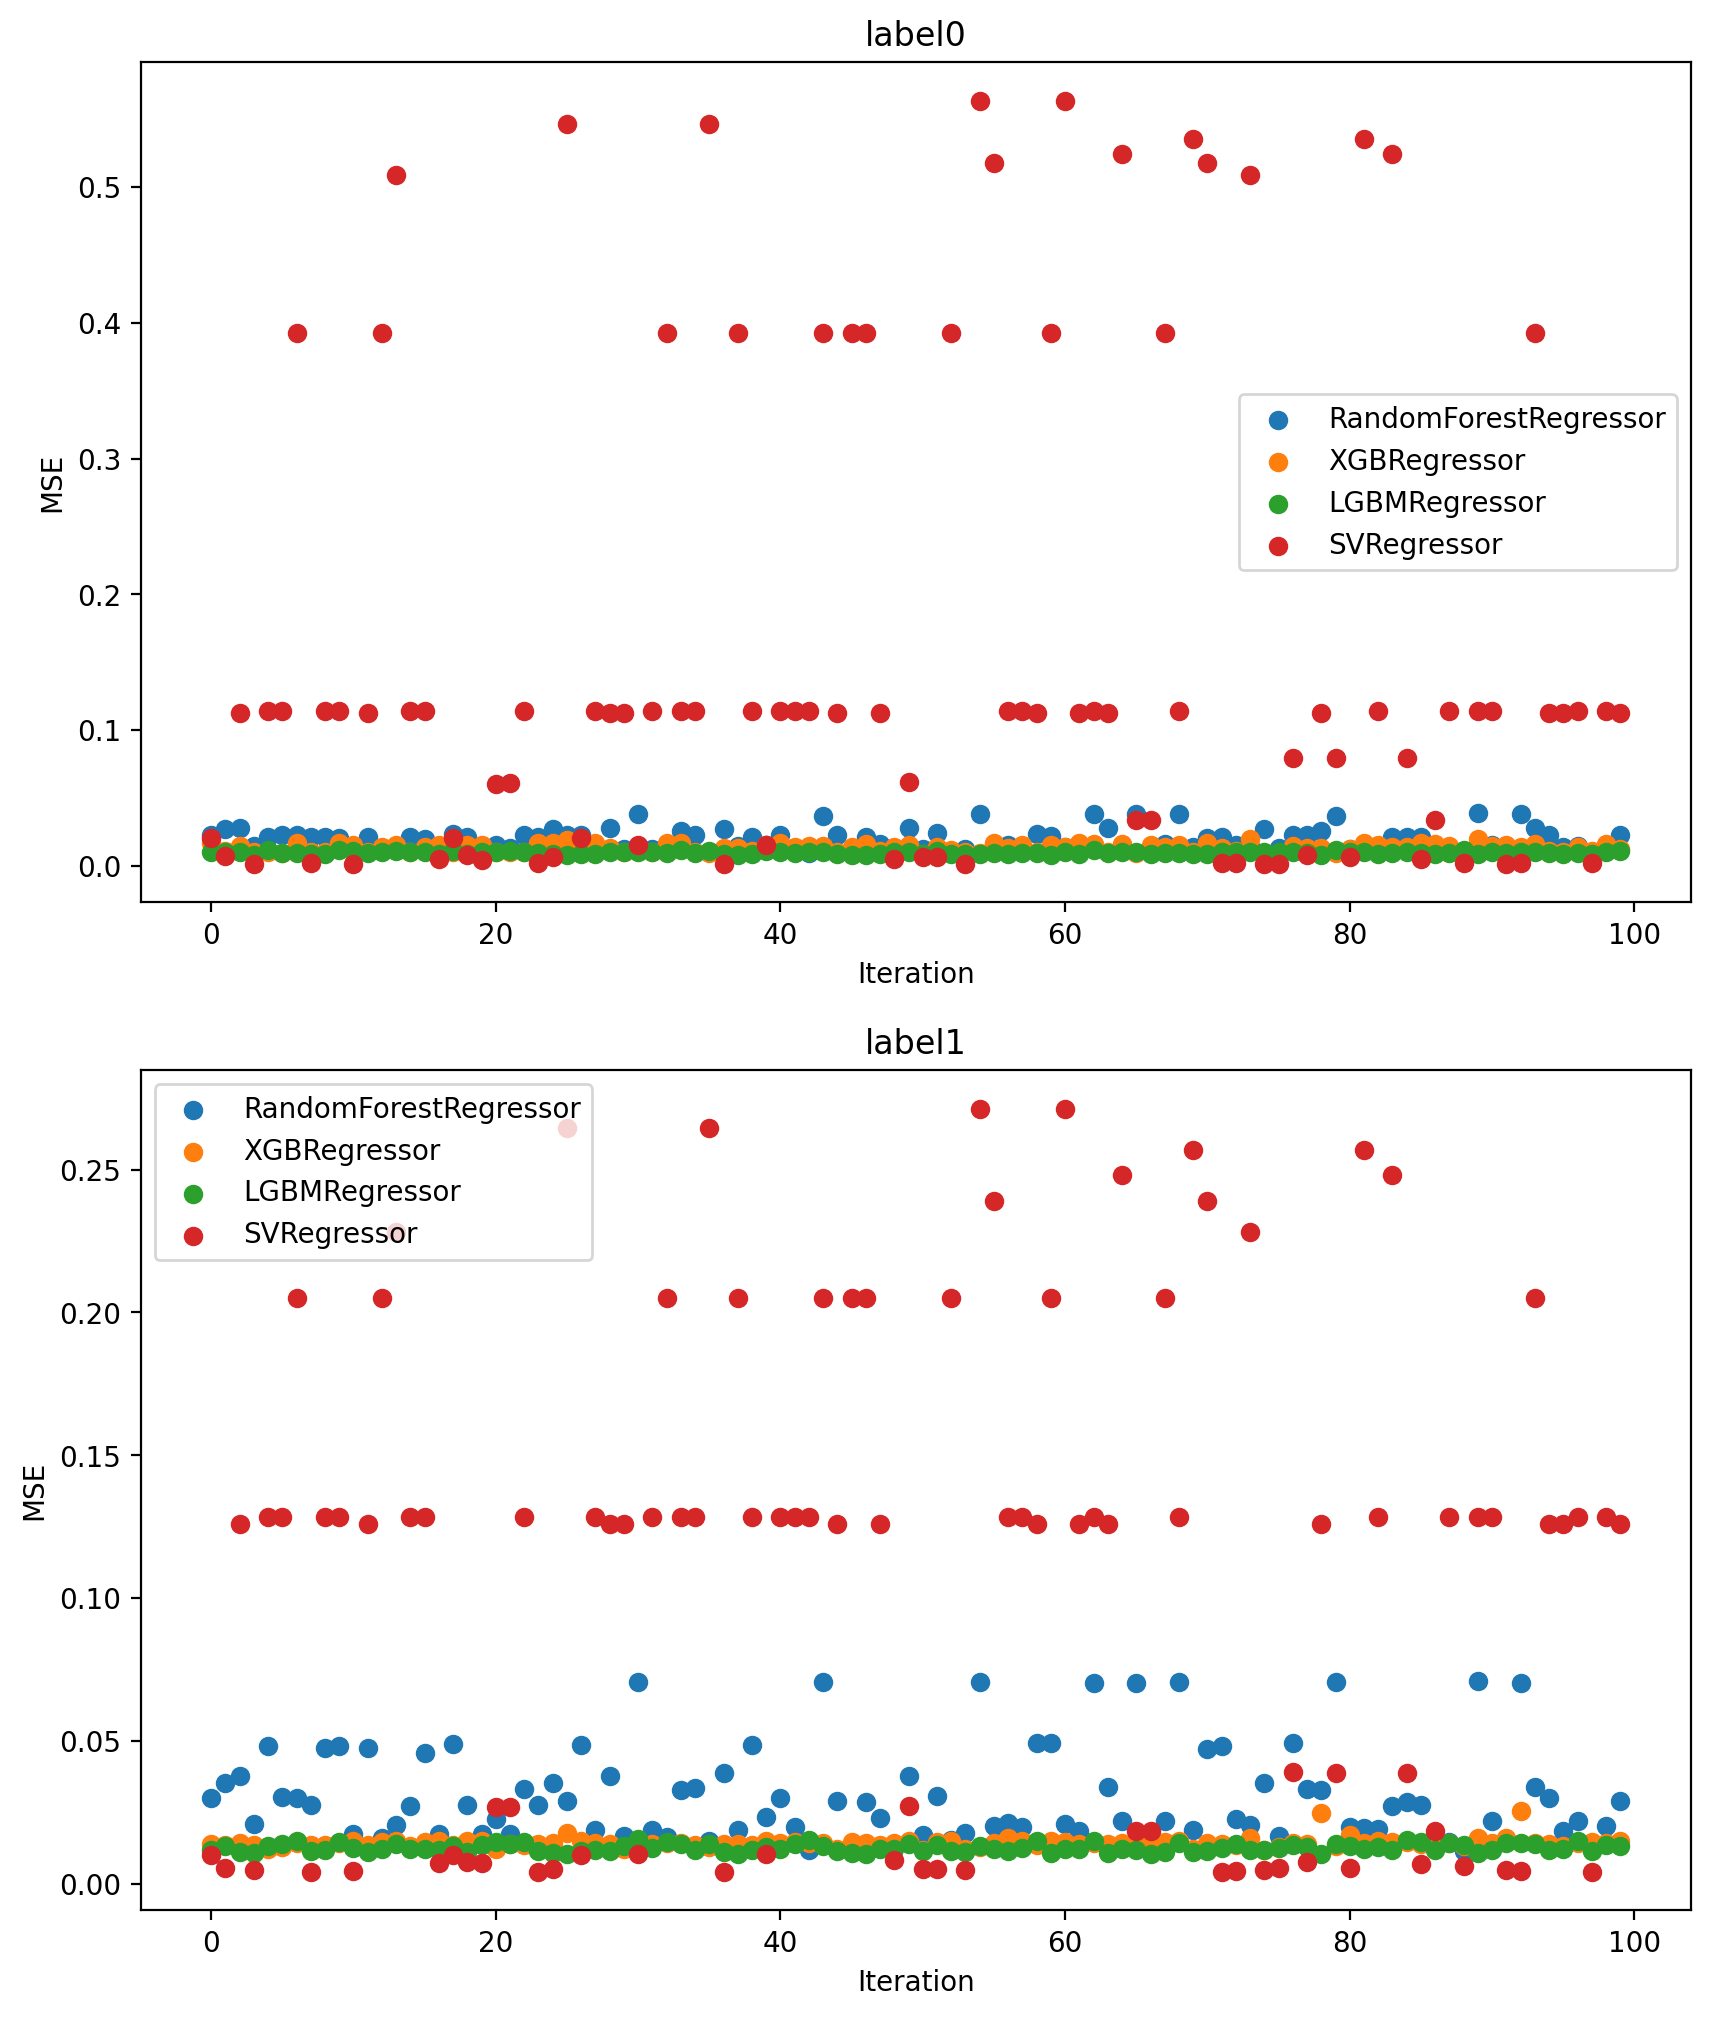

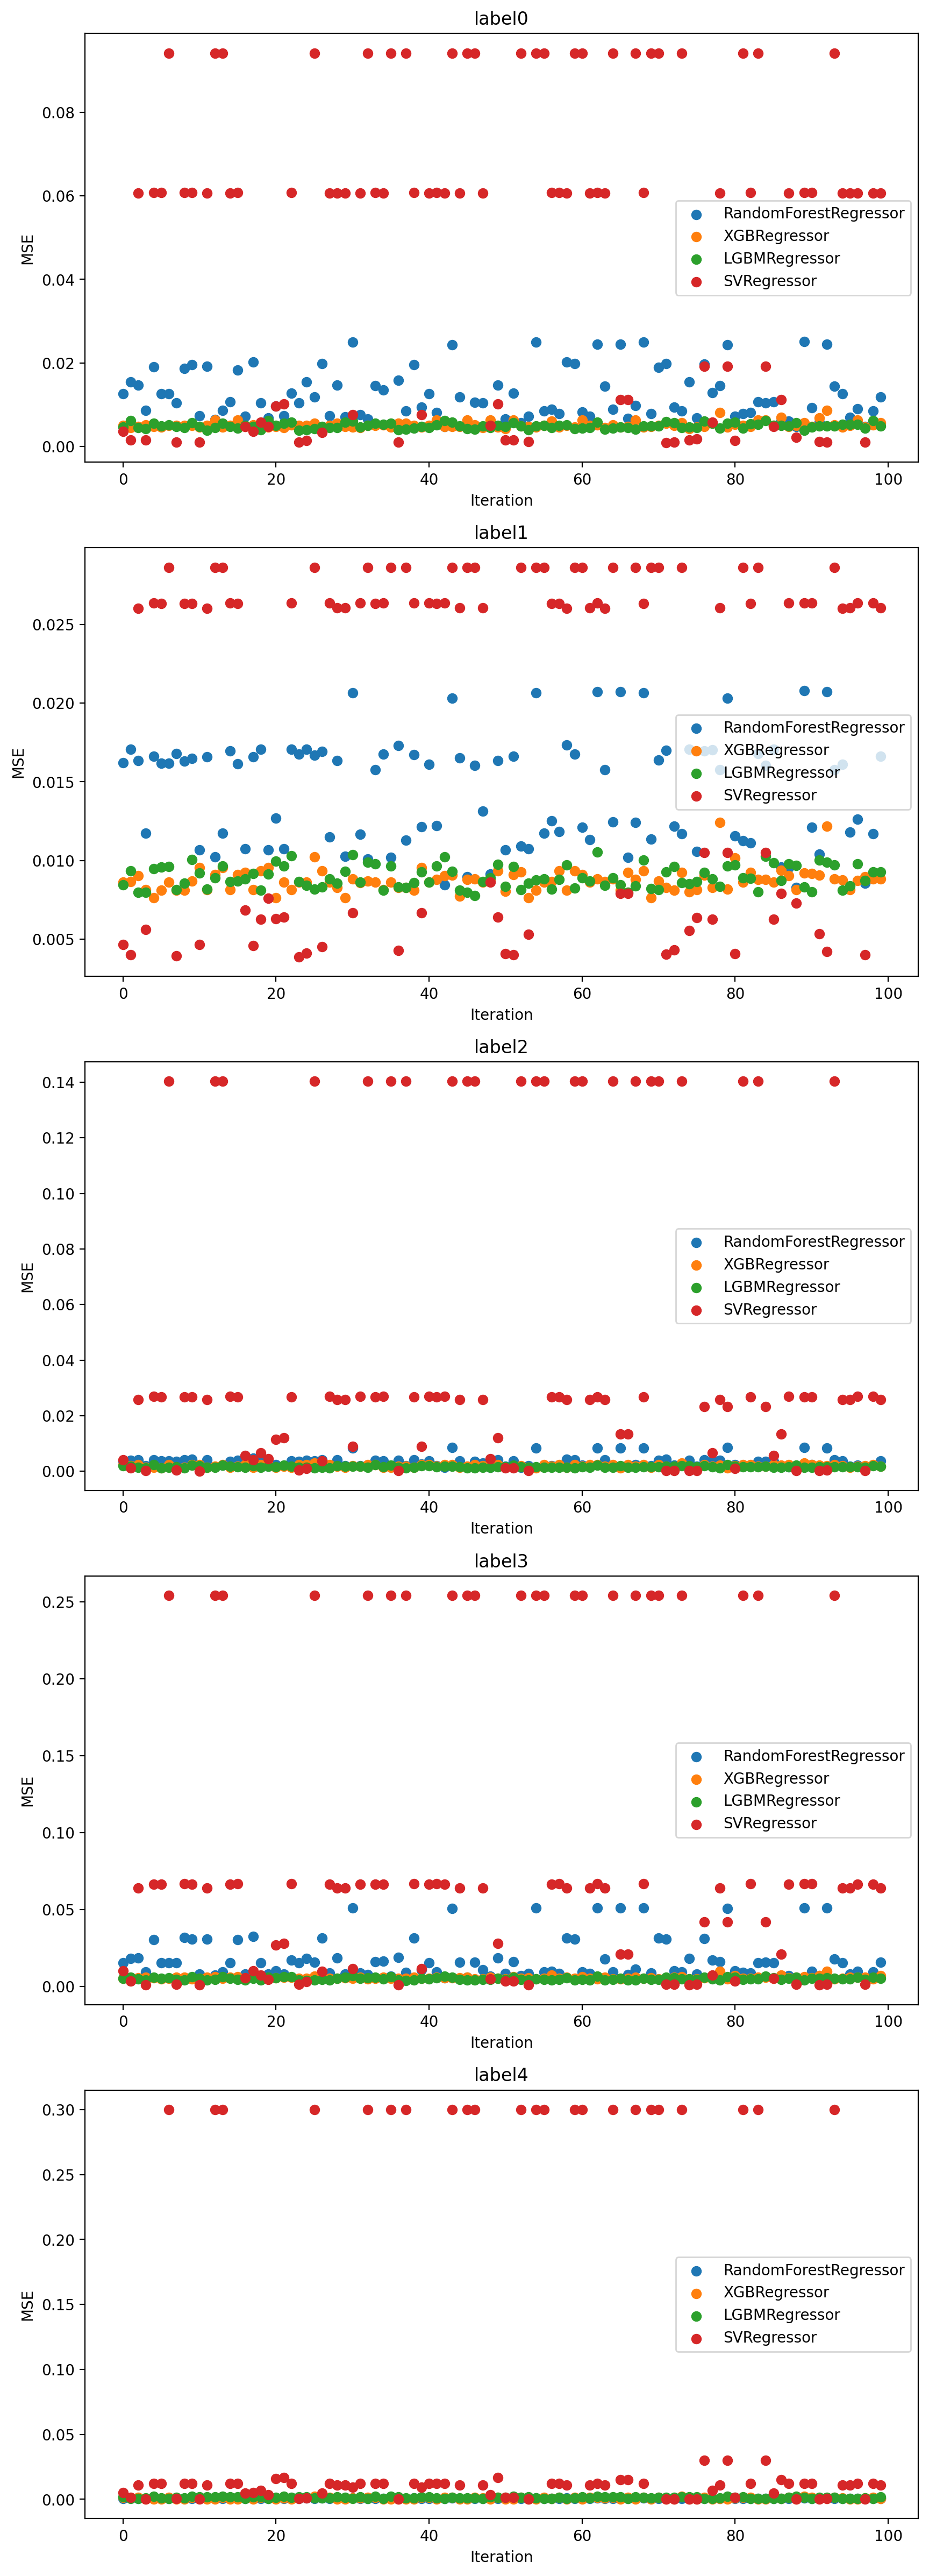

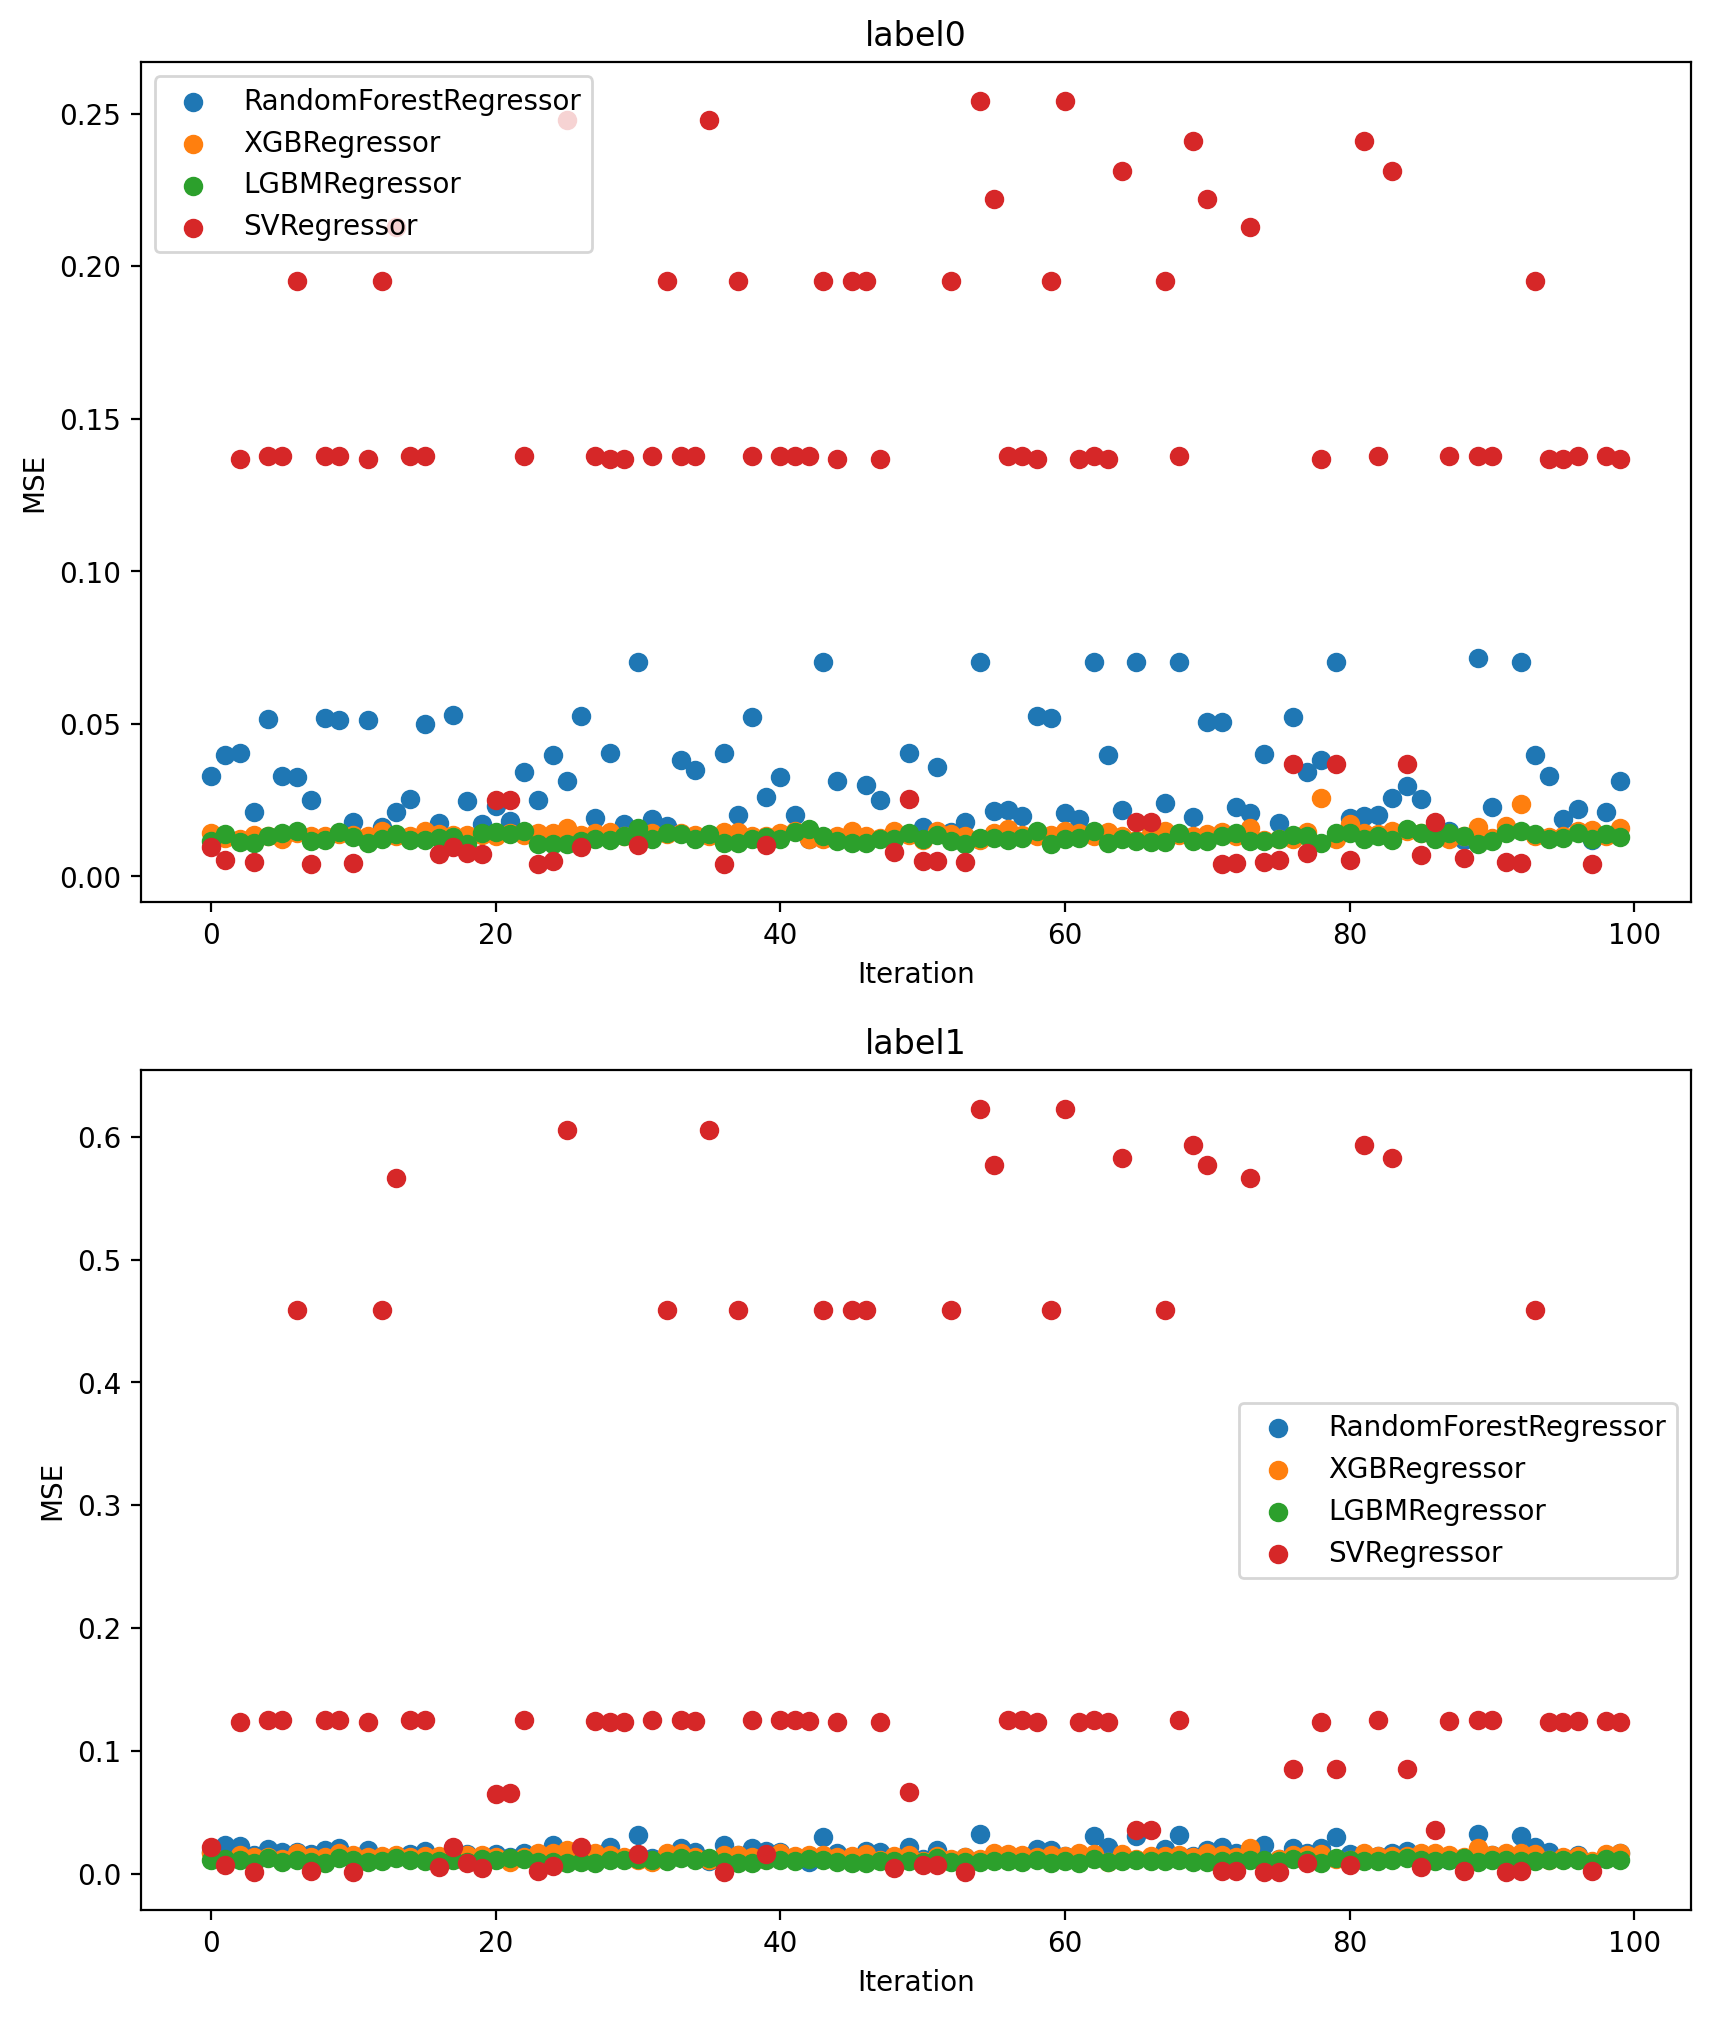

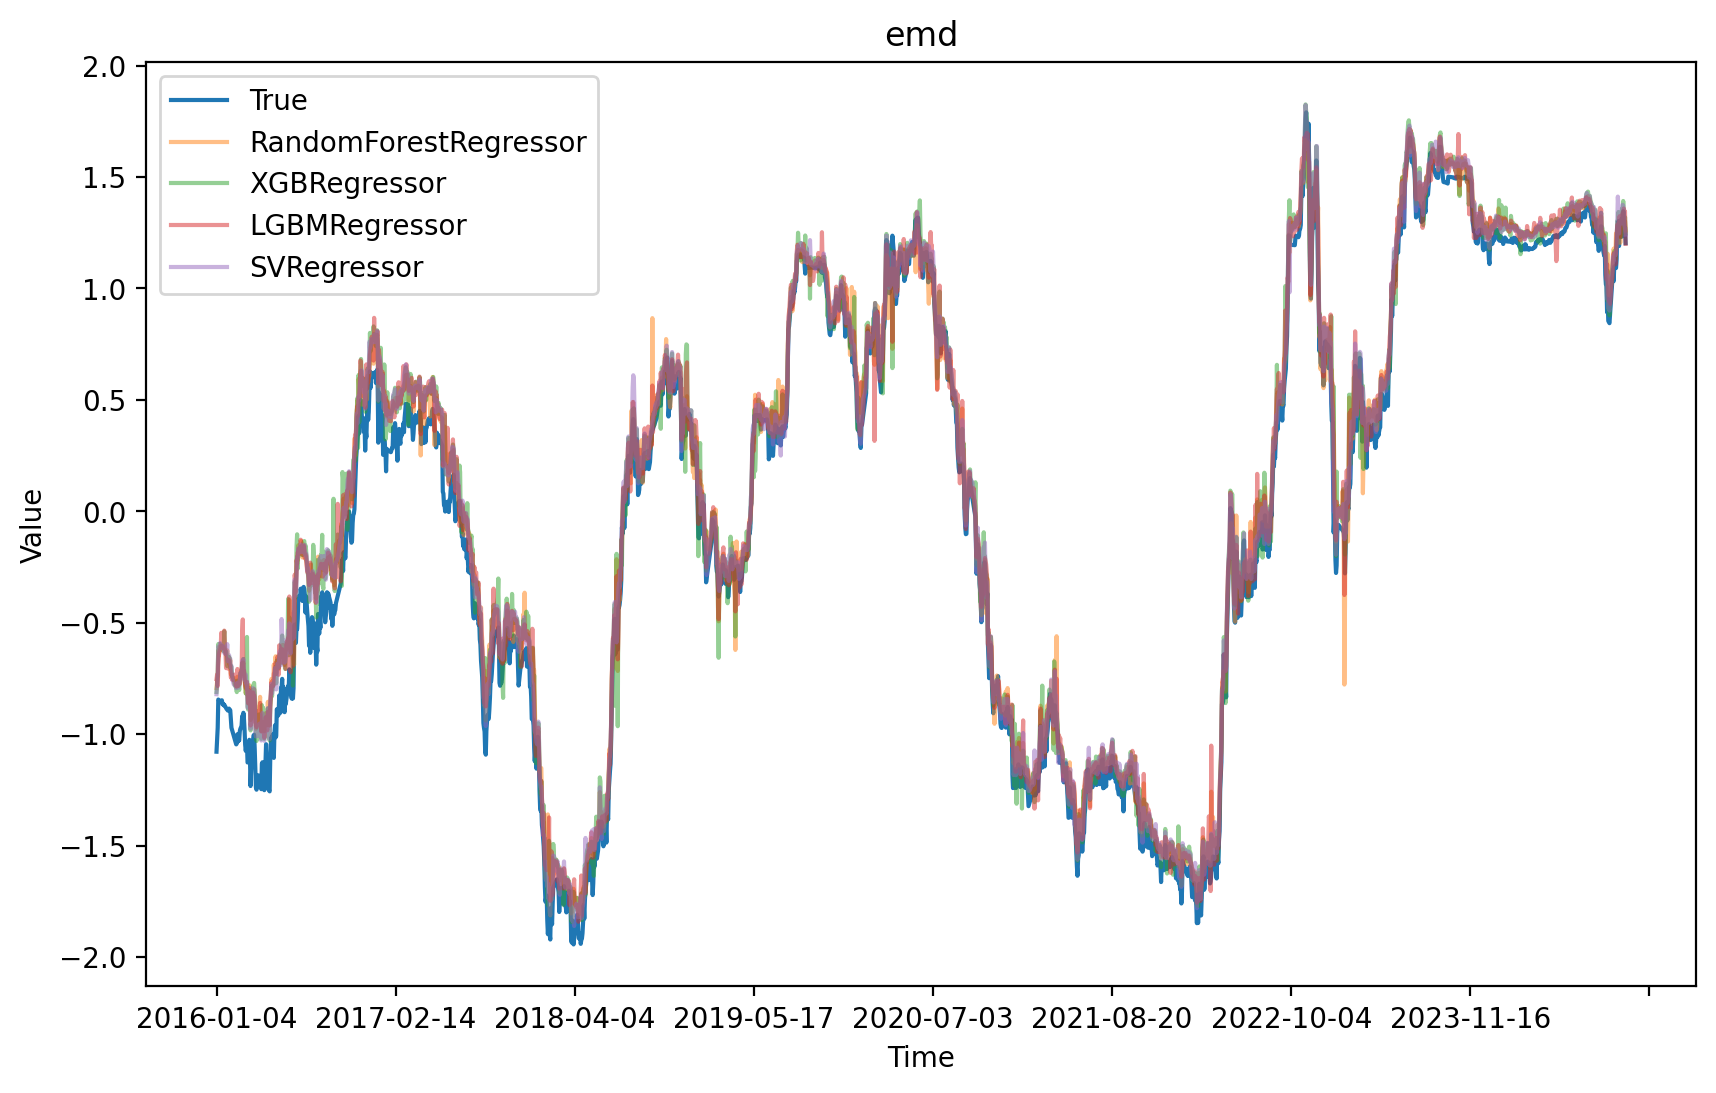

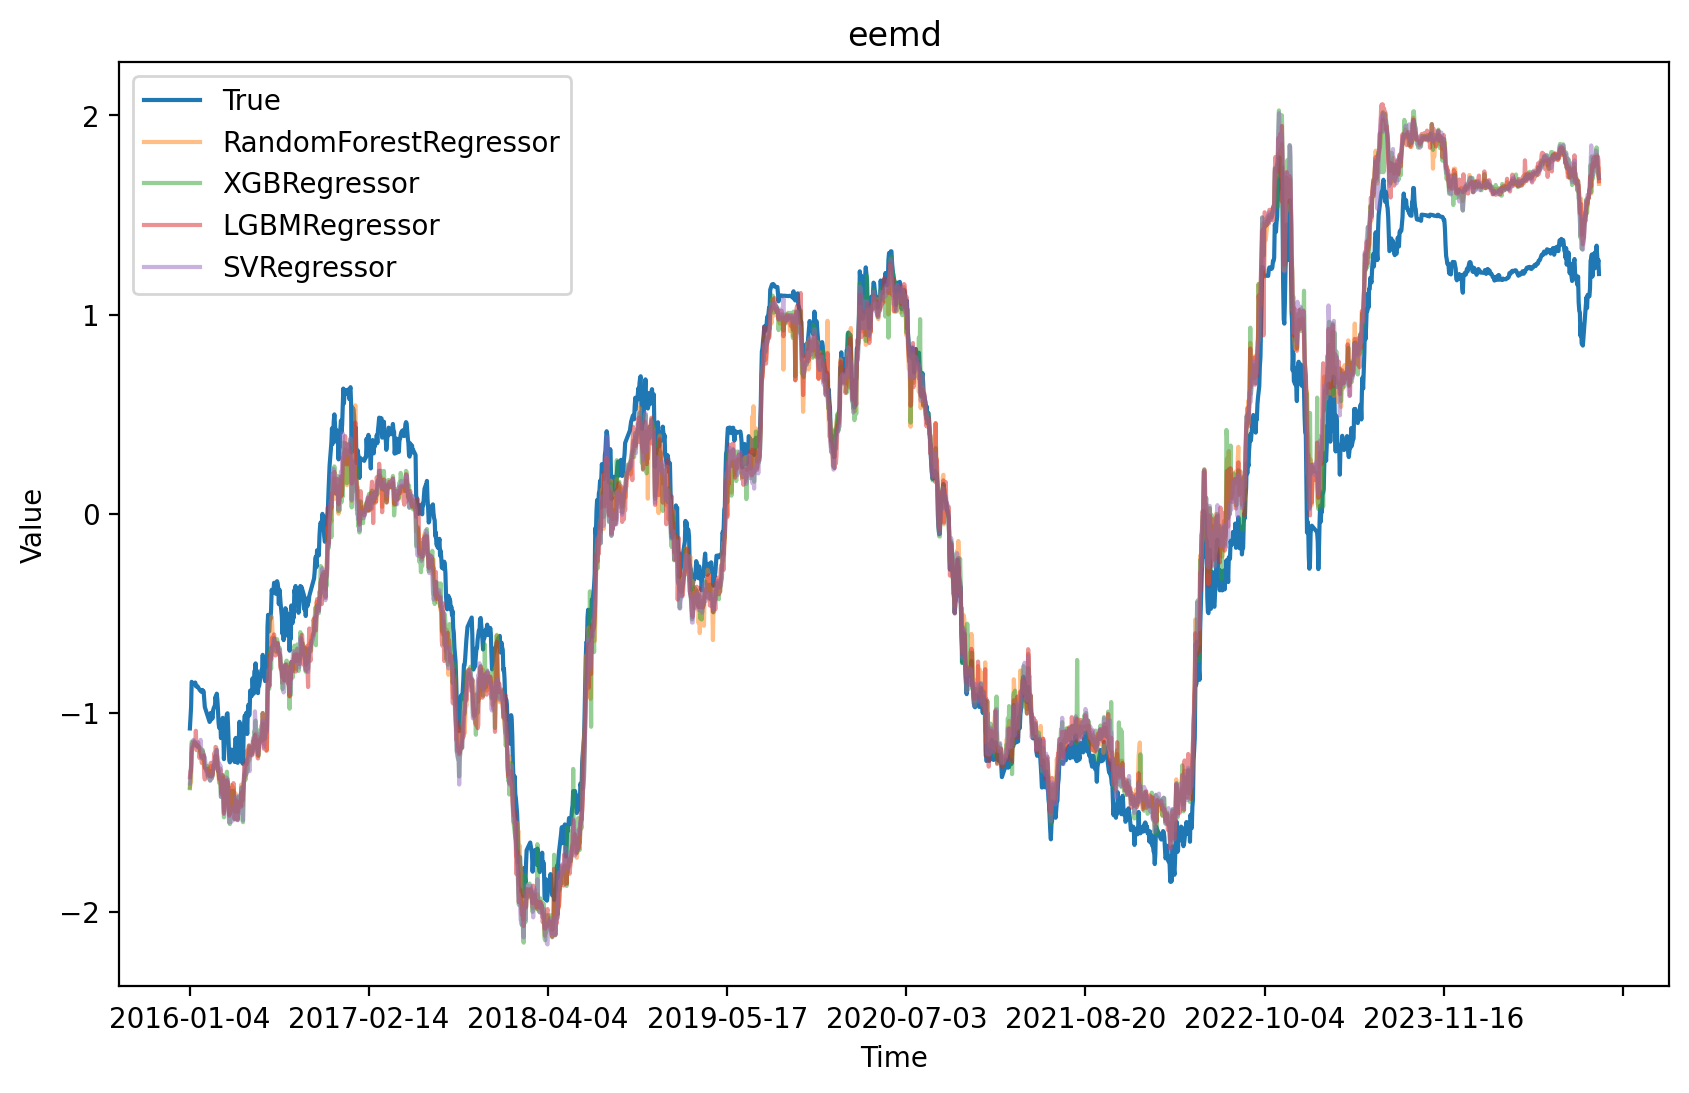

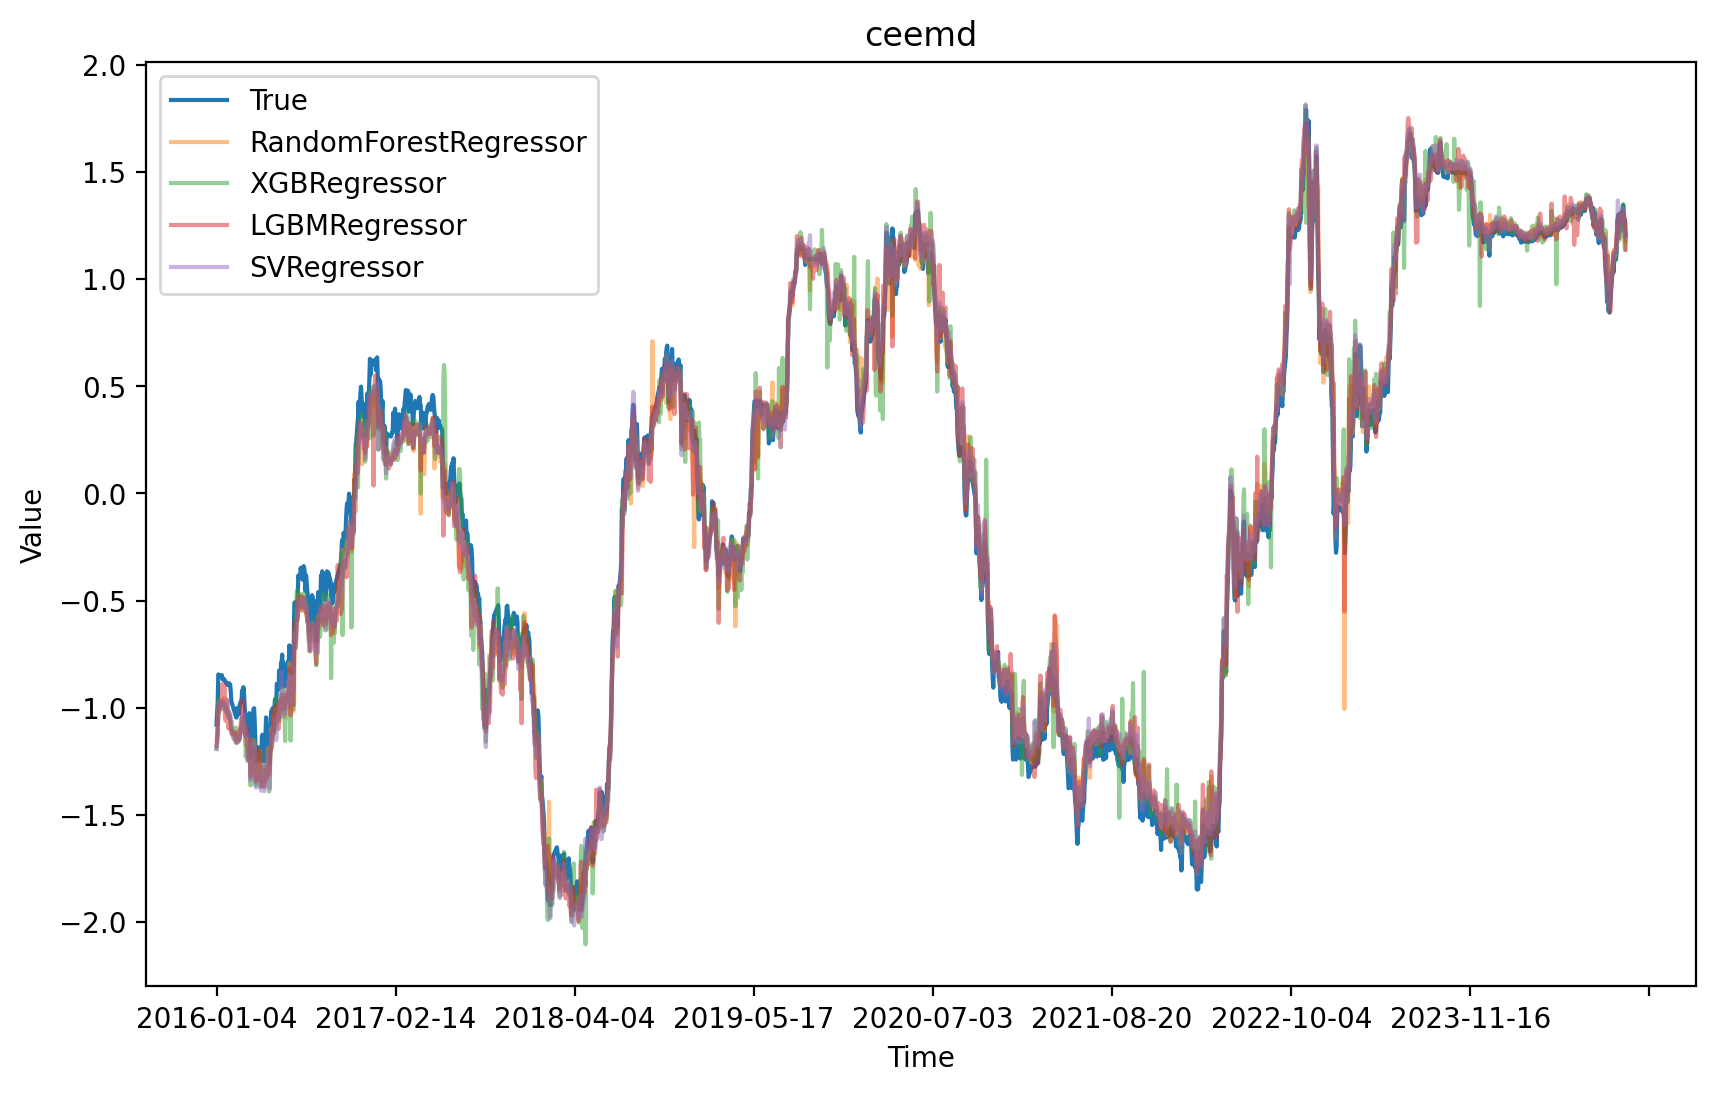

      RandomForestRegressor  XGBRegressor  LGBMRegressor  SVRegressor    imf
mse                0.014865      0.014331       0.014783     0.011463    emd
rmse               0.121921      0.119713       0.121585     0.107067    emd
mae                0.096029      0.094564       0.095139     0.086971    emd
mape              63.049374     64.648263      62.274638    48.061158    emd
mse                0.067546      0.066951       0.068011     0.064959   eemd
rmse               0.259896      0.258750       0.260789     0.254871   eemd
mae                0.223672      0.221894       0.223405     0.220270   eemd
mape              91.118269     93.570649      87.448721   102.769472   eemd
mse                0.009945      0.010996       0.009785     0.006192  ceemd
rmse               0.099727      0.104860       0.098917     0.078688  ceemd
mae                0.076302      0.078030       0.076659     0.064610  ceemd
mape              49.638835     69.361916      45.216428    34.527037  ceemd

In [17]:
X = pca_data
all_res1 = {}
for i in range(len(imf_names)):    
    all_res1[imf_names[i]] = find_regressor_params(X,imf_names[i])  
predict_result1 = predict_all_data(all_res1, imf_names, X, models)
regressor_performance(predict_result1, imf_names, models, d, pca='_pca')

## 结论

通过参数寻优对比预测结果可以发现，ceemd分解后SVR预测效果最好，参数为{'kernel': 'rbf', 'gamma': 0.5, 'epsilon': 0.01, 'C': 4}。